# Exploración de datos

Notebook para explorar los datos previavemente procesados y almacenados en *data_processed/data_processed.csv* 

Para obtener este dataset se utilizaron los notebooks que se encuentran en la carpeta *Extraccion_datos*.

1) Definición de cada atributo y sus características

2) Visualización

3) Estudio de correlaciones

4) Identificar mejoras a aplicar a los datos (transformaciones, datos extra, etc.). Conclusiones.

In [36]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import scipy.stats as ss
import statsmodels.api as sm
 
%matplotlib inline
plt.style.use('ggplot')

In [2]:
df=pd.read_csv('../data_processed/data_processed.csv',sep=';',index_col=False,parse_dates=['FECHA'])

In [3]:
pd.options.display.max_columns= None

In [4]:
df.head()

,FECHA,PERIODO,MES,WD,PRECIO_MD_ESP,ACOPLADO_FR,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,P48_CARBON_D-1,NUM_PLANTAS_D-1,EMB_ANUALES,EMB_HIPERANUALES,RESERVA
0,2015-10-01,1,10,4,56.65,0,0,2196.1,24517.1,10060.7,7181.4,22,3714,4909,1
1,2015-10-01,2,10,4,53.50,0,0,2064.4,23168.6,10060.7,6771.7,22,3714,4909,0
2,2015-10-01,3,10,4,49.69,0,0,1866.5,22437.2,10060.7,6559.5,22,3714,4909,0
3,2015-10-01,4,10,4,49.10,0,0,1660.9,22281.3,10060.7,6560.4,23,3714,4909,0
4,2015-10-01,5,10,4,51.25,0,0,1373.9,21909.7,10060.7,6724.1,23,3714,4909,0


In [5]:
df.dtypes

FECHA               datetime64[ns]
PERIODO                      int64
MES                          int64
WD                           int64
PRECIO_MD_ESP              float64
ACOPLADO_FR                  int64
RESERVA_D-1                  int64
P48_EOLICA                 float64
P48_DEMANDA                float64
POT_DISP_CARBON            float64
P48_CARBON_D-1             float64
NUM_PLANTAS_D-1              int64
EMB_ANUALES                  int64
EMB_HIPERANUALES             int64
RESERVA                      int64
dtype: object

In [6]:
df.isnull().any().any()  #comprobamos, aunque ya estaba testeado, que no hay NaN

False

## 1) Definición de cada atributo:

* **FECHA**: día de estudio. Formato %Y-%m-%d


* **PERIODO**: variable categórica que representa la hora del día expresado como la finalización de la hora de estudio. Es decir, el periodo 1 contiene la información del periodo comprendido entre las 00:00 y las 01:00. Toma valores desde 1 a 24.


* **MES**: variable categórica que toma valores del 1 al 12 para considerar el mes al que pertenece el día de estudio. 

    No todos los meses son iguales. En electricidad se suele simplificar hablando de Qs (trimestres). Así, el Q1 que comprende los meses de enero, febrero y marzo, se suelen caracterizar por alta eolicidad, demanda (invierno), hidraulicidad, mientras que en los meses del Q3, julio, agosto, septiembre, la eolicidad es más baja, desciende la aportación hidráulica, etc. Es por ello que se ha seleccionado el mes como una de las características a tener en cuenta.
    

* **WD**: variable categórica que toma valores del 1 al 7 para describir el día de la semana. Los festivos nacionales se han considerado tipo 7 (domingo).

    Se ha decidido considerar esta variable porque, tanto el comportamiento de la demanda como la generación, varía en función del día de la semana. Así, por ejemplo, las plantas de tecnología Cogeneración dejan de producir el fin de semana (6,7) dejando hueco a tecnologías más caras; la demanda es inferior el domingo/festivo que cualquier otro día lo que también impacta en estrategias de paradas/arranques de plantas y los costes que les suponen...
    

* **PRECIO_MD_ESP**: variable cuantitativa del precio de casación en el mercado diario para un PERIODO, FECHA.


* **ACOPLADO_FR**: variable categórica que representa el estado de la interconexión con Francia en el mercado diario MD. Toma valores:

    * -1: cuando la interconexion con Francia no se ha saturado en el MD y se está exportando generación de España a Francia (Acoplados, mismo precio en ambos paises en el MD)
    * 1: cuando la interconexion con Francia no se ha saturado en el MD y se está exportando generación de Francia a España (Acoplados, mismo precio en ambos paises en el MD)
    * 0: la interconexión está saturada en el MD. Ambos mercados desacoplados (no hay más hueco en la interconexión en uno de los dos sentidos) y los precios de casación en el MD son distintos.
    
    
* **Reserva_D-1**: Variable categórica que representa si en ese PERIODO, el día anterior, el precio del mercado intradiario fue inferior (1) o superior (0). Se considera en el dataset por pensar que puede haber una cierta tendencia e influencia de lo que ocurre el día anterior en el comportamiento de los agentes de mercado (reflejado en sus ofertas)y que tenga impacto en el resultado del día.


* **P48_EOLICA**: Variable cuantitativa de la producción eólica horaria. En el caso histórico será el programa al final del día (p48), mientras que, a la hora de predecir qué ocurrirá en el mercado (Reserva,target) será la mejor previsión de la misma, publicada por un proveedor particular de la empresa. 

    La eólica, desde el cambio regularorio en el que se impuso el impuesto a la generación, oferta a un precio próximo a los 5€/MWh. Recientemente se ha eliminado dicho impuesto aunque no se ha visto reflejado en el comportamiento del precio del mercado intradiario frente al diario.

    
* **P48_DEMANDA**: Variable cuantitativa de la demanda horaria. En el caso histórico será el programa al final del día (p48), mientras que, a la hora de predecir qué ocurrirá en el mercado (Reserva,target) será la mejor previsión de la misma, publicada por REE.   


* **POT_DISP_CARBON**: Variable cuantitativa de la potencia de generación disponible de carbón.


* **P48_CARBON_D-1**: Variable cuantitativa de la producción de carbón horaria que hubo el día anterior (a priori no tengo una previsión de la misma para el día D).



* **NUM_PLANTAS_D-1**: Variable cuantitativa del número de centrales de carbón que estaban arrancadas el día anterior (a priori no tengo una previsión de la misma para el día D).


* **EMB_ANUALES y EMB_HIPERANUALES**: Variable cuantitativa del total peninsular de la cantidad de energía eléctrica que se produciría en su propia central y en todas las centrales situadas aguas abajo, con el vaciado completo de su reserva útil de agua en dicho momento, en el supuesto de que este vaciado se realice sin aportaciones naturales. Los primeros son aquellos cuyo ciclo de llenado y vaciado dura un año mientras que los embalses de régimen hiperanual son aquellos que permiten compensar las variaciones de hidraulicidad en ciclos de más de un año de duración.

### El target es RESERVA: 

* 0 = Sube el intradiario, compro todo en el MD.

* 1 = Baja el intradiario, reservo parte de mi compra para comprarla más barata en el MI1.


In [7]:
subset_attributes=list(df.drop(['PERIODO','MES','WD','RESERVA'], axis=1).columns)  #Elimino las columnas de temporalidad
subset_attributes

baja_intra = round(df[df['RESERVA'] == 1][subset_attributes].describe(), 2)
sube_intra = round(df[df['RESERVA'] == 0][subset_attributes].describe(), 2)

pd.concat([baja_intra,sube_intra], axis=1, 
          keys=['📉 baja_intra',
                '📈 sube_intra'])

📉 baja_intra                                                 \
      PRECIO_MD_ESP ACOPLADO_FR RESERVA_D-1 P48_EOLICA P48_DEMANDA   
count      15138.00    15138.00    15138.00   15138.00    15138.00   
mean          49.00        0.09        0.61    5414.11    28626.06   
std           14.40        0.48        0.49    3158.20     4627.27   
min            2.06       -1.00        0.00     240.80    17728.40   
25%           41.10        0.00        0.00    2983.70    24688.58   
50%           50.00        0.00        1.00    4786.20    28885.75   
75%           59.41        0.00        1.00    7156.05    32251.00   
max          101.99        1.00        1.00   16761.10    41297.90   

                                                                  \
      POT_DISP_CARBON P48_CARBON_D-1 NUM_PLANTAS_D-1 EMB_ANUALES   
count        15138.00       15138.00        15138.00    15138.00   
mean          8646.56        4378.03           13.59     4662.87   
std            748.93        2165.67            6.10     1457.60   
min           5693.70         546.00            2.00     2222.00   
25%           8181.40        2403.00            8.00     3472.00   
50%           8796.60        4549.05           14.00     4572.00   
75%           9176.70        6164.85           19.00     5968.00   
max          10070.40        8763.80           25.00     7105.00   

                        📈 sube_intra                                     \
      EMB_HIPERANUALES PRECIO_MD_ESP ACOPLADO_FR RESERVA_D-1 P48_EOLICA   
count         15138.00      11163.00    11163.00    11163.00   11163.00   
mean           4164.49         48.39        0.07        0.53    5567.90   
std            1305.12         15.67        0.51        0.50    3221.37   
min            2138.00          2.31       -1.00        0.00     352.50   
25%            2932.00         39.25        0.00        0.00    3086.50   
50%            4266.00         48.65        0.00        1.00    4879.30   
75%            5004.00         59.52        0.00        1.00    7475.90   
max            6472.00         99.18        1.00        1.00   16952.60   

                                                                              \
      P48_DEMANDA POT_DISP_CARBON P48_CARBON_D-1 NUM_PLANTAS_D-1 EMB_ANUALES   
count    11163.00        11163.00       11163.00        11163.00    11163.00   
mean     28739.05         8554.27        4460.48           13.86     4580.54   
std       4599.53          737.86        2288.16            6.48     1471.39   
min      17982.60         5693.70         546.00            2.00     2222.00   
25%      24816.15         8086.50        2208.05            7.00     3429.00   
50%      28968.80         8617.80        4773.90           15.00     4545.00   
75%      32297.25         9082.60        6456.65           19.00     5726.00   
max      40394.20        10070.40        8768.30           25.00     7105.00   

                        
      EMB_HIPERANUALES  
count         11163.00  
mean           4141.69  
std            1301.01  
min            2138.00  
25%            3137.00  
50%            4143.00  
75%            5004.00  
max            6472.00

A primera vista no se observan diferencias estadísticas en los atributos cuando baja/sube el intra.

## 2) Visualización:

### 2.1. Lo primero compruebo si los datos están desbalanceados o si tiene alguna tendencia temporal que condicione la selección del train_set.

Descarto que el hecho de seleccionar un conjunto de datos u otro manipule el resultado. 

Por ejemplo, que la situación de bajada del precio del intradiario se concentre en un momento puntual de mi dataset que, de no seleccionar en el training, provocaría que la salida de mi modelo siempre fuese 0. 

In [8]:
df['RESERVA'].value_counts(normalize=True)

1    0.575567
0    0.424433
Name: RESERVA, dtype: float64

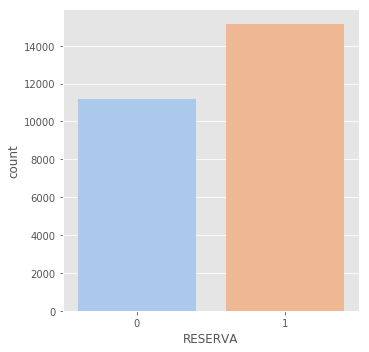

In [9]:
#Para usar sns.catplot es necesario contar con la última actualización de seaborn: v0.9.0

#conda update seaborn

g=sns.catplot('RESERVA',data=df,kind='count',palette='pastel')
plt.show()

Aunque hay más horas donde baja el intradiario, está bastante equilibrado en número de horas de subida vs. bajada.

Compruebo si existe sesgo de RESERVA en algún año o entre 1 año y otro. 

Me ayudo de 3 dataset distintos, cada uno un año hidráulico, y añado columna *ANHO* que representa el año hidráulico al que pertenecen:

*NOTA: El año hidráulico comienza en octubre y finaliza en septiembre, por considerarse octubre el primer mes de lluvias. Por ello nuestro dataset se inició en octubre 2015.*

In [10]:
df_anho=df.copy()  #Creamos copia de df

In [11]:
anho=pd.to_datetime(['2016-10-01','2017-10-01','2018-10-01'],format='%Y-%m-%d')
anho  #límite del año hidraúlico

DatetimeIndex(['2016-10-01', '2017-10-01', '2018-10-01'], dtype='datetime64[ns]', freq=None)

In [12]:
#Función para crear año hidráulico
def anho_hidraulico(elem):
    if elem<anho[0]:
        return 1;
    elif elem<anho[1]:
        return 2;
    else:
        return 3;

In [13]:
df_anho['ANHO']=list(df_anho['FECHA'].map(anho_hidraulico))
df_anho.sample(10)  #Comprobamos correcto funcionamiento:

,FECHA,PERIODO,MES,WD,PRECIO_MD_ESP,ACOPLADO_FR,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,P48_CARBON_D-1,NUM_PLANTAS_D-1,EMB_ANUALES,EMB_HIPERANUALES,RESERVA,ANHO
14705,2017-06-04,20,6,7,38.60,0,1,6829.8,24108.7,8611.8,4465.1,17,4572,2932,0,2
15646,2017-07-14,1,7,5,53.36,0,1,6534.9,31673.0,9380.0,6793.8,19,4017,2852,1,2
1810,2015-12-15,11,12,2,59.56,0,1,7739.8,34887.6,10070.4,8694.8,24,3837,4807,0,1
13379,2017-04-10,14,4,1,50.50,0,1,2827.8,30891.7,8280.4,1919.0,7,4709,3294,0,2
7868,2016-08-23,22,8,2,44.10,0,0,5348.1,34344.1,8651.5,6795.8,19,4545,5182,1,1
10003,2016-11-20,21,11,7,51.67,1,1,12270.6,30030.5,8056.5,6647.7,20,3472,4266,1,2
13089,2017-03-29,12,3,3,48.47,0,0,3600.8,32332.8,6974.5,4880.8,13,4751,3421,0,2
9395,2016-10-26,13,10,3,65.69,0,1,1502.9,32346.7,7789.5,6761.6,21,3148,4491,1,2
3272,2016-02-14,9,2,7,3.00,0,1,9685.7,23195.8,9676.8,1010.5,4,6078,5988,1,1
17246,2017-09-18,17,9,1,43.92,1,1,7000.1,30343.5,9235.0,2274.9,10,2576,2560,0,2


In [14]:
df_anho_1=df_anho[df_anho['ANHO']==1]
df_anho_2=df_anho[df_anho['ANHO']==2]
df_anho_3=df_anho[df_anho['ANHO']==3]

In [17]:
df_anho_1.describe()

,PERIODO,MES,WD,PRECIO_MD_ESP,ACOPLADO_FR,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,P48_CARBON_D-1,NUM_PLANTAS_D-1,EMB_ANUALES,EMB_HIPERANUALES,RESERVA,ANHO
count,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000,8783.0
mean,12.501082,6.514061,4.059775,38.347133,0.070249,0.582147,5717.254048,28290.361186,8764.754526,3957.501025,12.467494,5313.718092,5579.858818,0.582261,1.0
std,6.922232,3.451423,2.008625,13.824983,0.495212,0.493234,3259.886621,4497.364263,767.408112,2516.588641,7.138322,1231.348977,629.258607,0.493215,0.0
min,1.000000,1.000000,1.000000,2.300000,-1.000000,0.000000,281.600000,17728.400000,6794.400000,546.000000,3.000000,3714.000000,4778.000000,0.000000,1.0
25%,7.000000,4.000000,2.000000,30.300000,0.000000,0.000000,3198.350000,24441.900000,8273.800000,1534.850000,5.000000,3837.000000,4909.000000,0.000000,1.0
50%,13.000000,7.000000,4.000000,39.690000,0.000000,1.000000,5079.400000,28625.400000,8833.800000,3544.500000,11.000000,5609.000000,5538.000000,1.000000,1.0
75%,18.500000,10.000000,6.000000,46.645000,0.000000,1.000000,7551.000000,31834.550000,9419.100000,6297.100000,20.000000,6134.000000,6172.000000,1.000000,1.0
max,24.000000,12.000000,7.000000,85.000000,1.000000,1.000000,16670.800000,40329.400000,10070.400000,8768.300000,25.000000,7105.000000,6472.000000,1.000000,1.0


In [18]:
df_anho_2.describe()

,PERIODO,MES,WD,PRECIO_MD_ESP,ACOPLADO_FR,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,P48_CARBON_D-1,NUM_PLANTAS_D-1,EMB_ANUALES,EMB_HIPERANUALES,RESERVA,ANHO
count,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.0
mean,12.501085,6.526430,4.081859,51.869141,0.086425,0.553602,5051.412410,28631.728382,8403.119009,4983.807261,15.544583,3872.105149,3370.988812,0.554972,2.0
std,6.922233,3.448039,2.020118,11.534649,0.477583,0.497147,2909.568958,4590.374770,766.775829,1892.674732,5.326177,778.815437,574.456965,0.496997,0.0
min,1.000000,1.000000,1.000000,2.300000,-1.000000,0.000000,468.200000,18277.400000,5693.700000,921.200000,4.000000,2576.000000,2560.000000,0.000000,2.0
25%,7.000000,4.000000,2.000000,45.000000,0.000000,0.000000,2867.550000,24719.450000,7889.800000,3467.150000,11.000000,3148.000000,2852.000000,0.000000,2.0
50%,13.000000,7.000000,4.000000,50.930000,0.000000,1.000000,4456.600000,28896.500000,8535.500000,5294.900000,17.000000,3472.000000,3294.000000,1.000000,2.0
75%,18.500000,10.000000,6.000000,56.625000,0.000000,1.000000,6561.600000,32146.350000,8969.200000,6579.750000,20.000000,4709.000000,3843.000000,1.000000,2.0
max,24.000000,12.000000,7.000000,101.990000,1.000000,1.000000,16384.700000,41297.900000,9534.700000,8316.400000,24.000000,4931.000000,4491.000000,1.000000,2.0


In [19]:
df_anho_3.describe()

,PERIODO,MES,WD,PRECIO_MD_ESP,ACOPLADO_FR,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,P48_CARBON_D-1,NUM_PLANTAS_D-1,EMB_ANUALES,EMB_HIPERANUALES,RESERVA,ANHO
count,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.0
mean,12.501085,6.526430,4.101039,56.032261,0.089394,0.589451,5668.838292,29101.000662,8653.860475,4299.014739,13.105491,4696.079461,3509.681585,0.589451,3.0
std,6.922233,3.448039,2.032101,13.253325,0.499029,0.491962,3329.363919,4721.669470,649.892439,2074.705405,5.751540,1806.031249,1143.379475,0.491962,0.0
min,1.000000,1.000000,1.000000,2.060000,-1.000000,0.000000,240.800000,18591.400000,5808.600000,669.300000,2.000000,2222.000000,2138.000000,0.000000,3.0
25%,7.000000,4.000000,2.000000,49.440000,0.000000,0.000000,3023.950000,25033.300000,8334.200000,2346.050000,7.000000,2617.000000,2267.000000,0.000000,3.0
50%,13.000000,7.000000,4.000000,58.680000,0.000000,1.000000,4980.700000,29257.600000,8799.100000,4607.600000,14.000000,5172.000000,3731.000000,1.000000,3.0
75%,18.500000,10.000000,6.000000,64.400000,0.000000,1.000000,7789.300000,32891.000000,9153.600000,5987.900000,18.000000,5968.000000,4521.000000,1.000000,3.0
max,24.000000,12.000000,7.000000,90.000000,1.000000,1.000000,16952.600000,40921.600000,9534.700000,8656.100000,24.000000,7092.000000,5004.000000,1.000000,3.0


Se define también vector orden: El primer mes del año hidráulico es el 10 (octubre)

In [20]:
order=[10,11,12,1,2,3,4,5,6,7,8,9]

In [21]:
#Veo la proporción de horas en las que baja/sube el intradiario cada año

df_anho.groupby(['ANHO'])['RESERVA'].value_counts(normalize=True,sort=False)*100

ANHO  RESERVA
1     0          41.773881
      1          58.226119
2     0          44.502797
      1          55.497203
3     0          41.054915
      1          58.945085
Name: RESERVA, dtype: float64

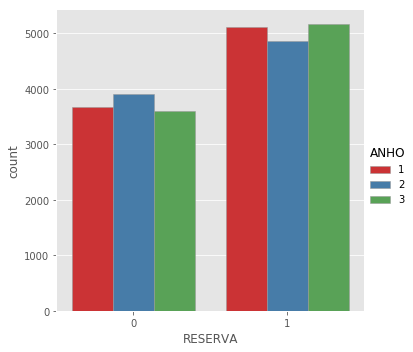

In [22]:
sns.catplot('RESERVA', hue='ANHO', kind='count',
            palette='Set1', edgecolor=".6",
            data=df_anho);

Aunque sí hay más proporción de horas en las que baja el precio del intradiario en todos los años, de nuevo la diferencia no la considero significativa en ningún año (41% vs. 59% el que más). También, si se valoran individualmente los años, el resultado es análogo en los 3. No tendría problemas a la hora de seleccionar mi train-test dataset.

Por tanto, se concluye que **por años** el target RESERVA **no esta sesgado**.

¿Por meses?

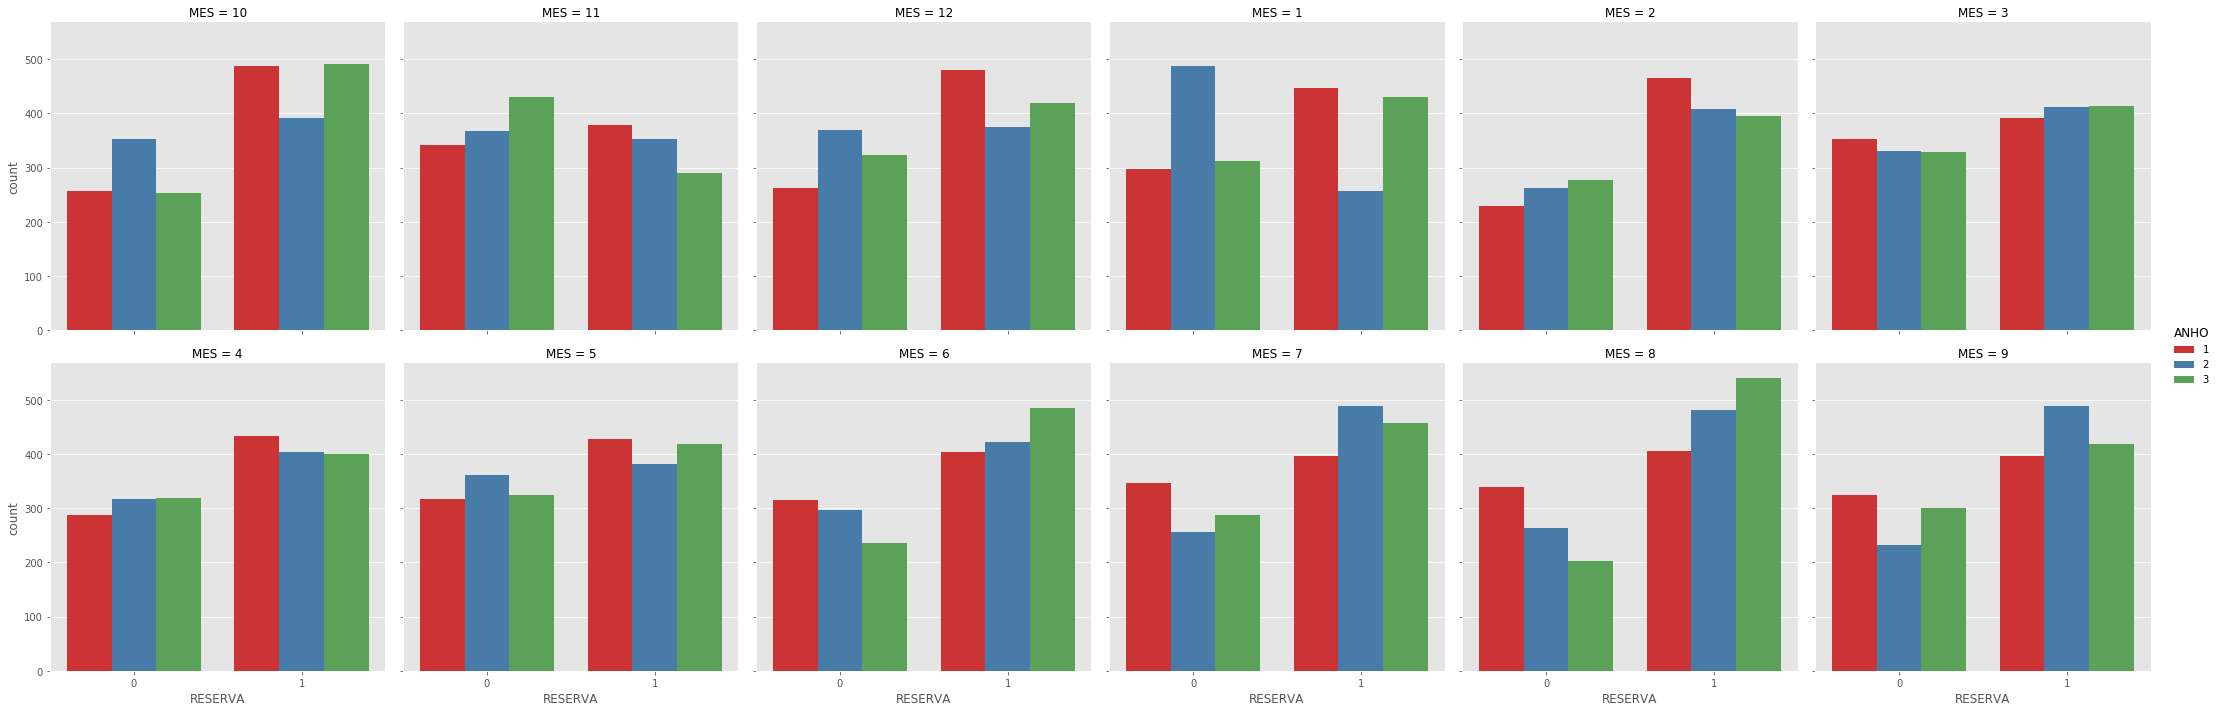

In [23]:
sns.catplot('RESERVA',data=df_anho,kind='count',
            hue='ANHO',col='MES',
            col_order=order,palette='Set1',col_wrap=6);

Sí hay meses donde se ha dado más un caso que otro *(oct15,feb16,ene17,sept17,junio18...)*, aunque sin un patrón repetitivo que indique desbalanceo de los datos (por lo general, continúa la tendencia de ligera mayor proporción de horas de bajada del intra frente a subida).

          Aquí aparece la 1ª duda:

          DUDA: ¿Es el mes una feature a considerar en el modelo o va intrínseca en el resto de variables? Lo estudiaré mas adelante


#### Estudio de RESERVA en función de otras variables categóricas temporales: laboralidad (WD):

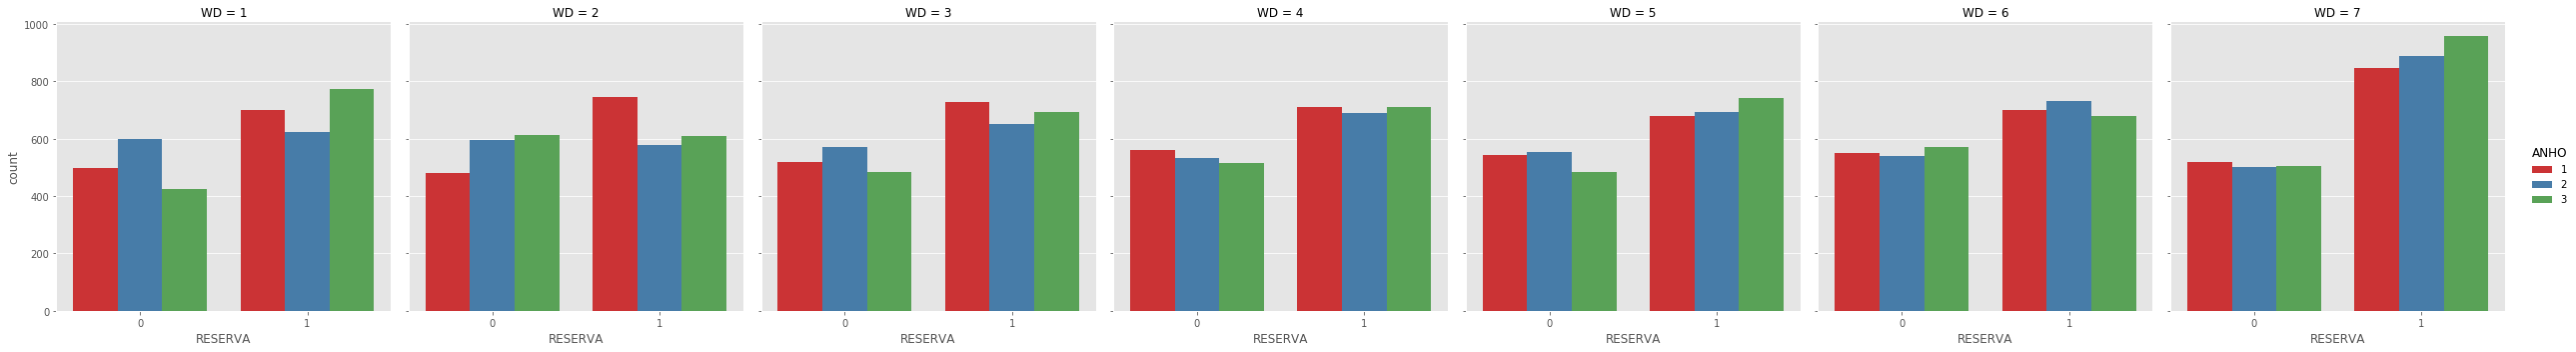

In [24]:
sns.catplot('RESERVA',data=df_anho,kind='count',
            hue='ANHO',col='WD',
            palette='Set1');

En los gráficos superiores se observa como en los 3 años, el domingo tiene una clara mayor proporción de horas de bajada del intradiario. 

El resto de días no presentan un comportamiento evidente visualmente ni distinto al observado antes de la discriminación por día de la semana. **Igualmente, sí encuentro importante considerar el weekday como feature de entrada**.

### 2.2. Examinamos relación Reserva consigo misma: Reserva D-1

La reserva es una variable categórica que puede tomar solo valores 0/1. Con la función *tsa.filters.hpfilter* de la librería *statmodels* saco la línea de tendencia resultado de representar la evolución en el tiempo de la variable RESERVA.

**Hodrick-Prescott filter**

Esta funcionalidad la descubrí consultando métodos para comprobar autocorrelación de variables. Para seleccionar la lambda aplicada, además de la ayuda de jupyter, he consultado en google cuál sería un valor apropiado y he encontrado la mejor info en el siguiente enlace en el que también explica en qué consiste *Hodrick-Prescott filter*:
http://www.neuroshell.com/manuals/ais1/index.html?hodrickprescottfilter.htm
que explica:

"Cálculos

Dada la serie temporal de entrada y (i), donde i = 1..N, el filtro Hodrick-Prescott produce una línea de tendencia suavizada s(i), que minimiza la siguiente función objetivo F:
F = Suma (i = 1 a N) [y (i) - s (i)] ^ 2 + Smoothing*Suma (i = 2 a N-1) [(s (i + 1) -s (i)) - (s (i) -s (i-1))] ^ 2

*Cuanto mayor sea el parámetro lamb, más suave será la línea de tendencia s (i). A medida que el parámetro lamb va a infinito, la línea de tendencia s (i) se convierte en una tendencia lineal. Para datos trimestrales, Hodrick y Prescott [1] usaron lamb = 1600. Para los datos mensuales, un valor comúnmente aceptado es 14400. Para los datos diarios, el parámetro Suavizado puede ser desde 10000 a 10 ^ 8 o incluso más, según el comportamiento de la Serie de Entrada y el grado de suavizado requerido.*"

Tan solo utilizaré esta función para ver si podría haber cierta tendencia, y hacer una comprobación burda de si la elección del dato RESERVA_D-1 tiene sentido como feature de entrada.

In [25]:
sm.tsa.filters.hpfilter?

Signature: sm.tsa.filters.hpfilter(X, lamb=1600)
Docstring:
Hodrick-Prescott filter

Parameters
----------
X : array-like
    The 1d ndarray timeseries to filter of length (nobs,) or (nobs,1)
lamb : float
    The Hodrick-Prescott smoothing parameter. A value of 1600 is
    suggested for quarterly data. Ravn and Uhlig suggest using a value
    of 6.25 (1600/4**4) for annual data and 129600 (1600*3**4) for monthly
    data.

Returns
-------
cycle : array
    The estimated cycle in the data given lamb.
trend : array
    The estimated trend in the data given lamb.

Examples
---------
>>> import statsmodels.api as sm
>>> import pandas as pd
>>> dta = sm.datasets.macrodata.load_pandas().data
>>> index = pd.DatetimeIndex(start='1959Q1', end='2009Q4', freq='Q')
>>> dta.set_index(index, inplace=True)

>>> cycle, trend = sm.tsa.filters.hpfilter(dta.realgdp, 1600)
>>> gdp_decomp = dta[['realgdp']]
>>> gdp_decomp["cycle"] = cycle
>>> gdp_decomp["trend"] = trend

>>> import matplotlib.pyplot as plt

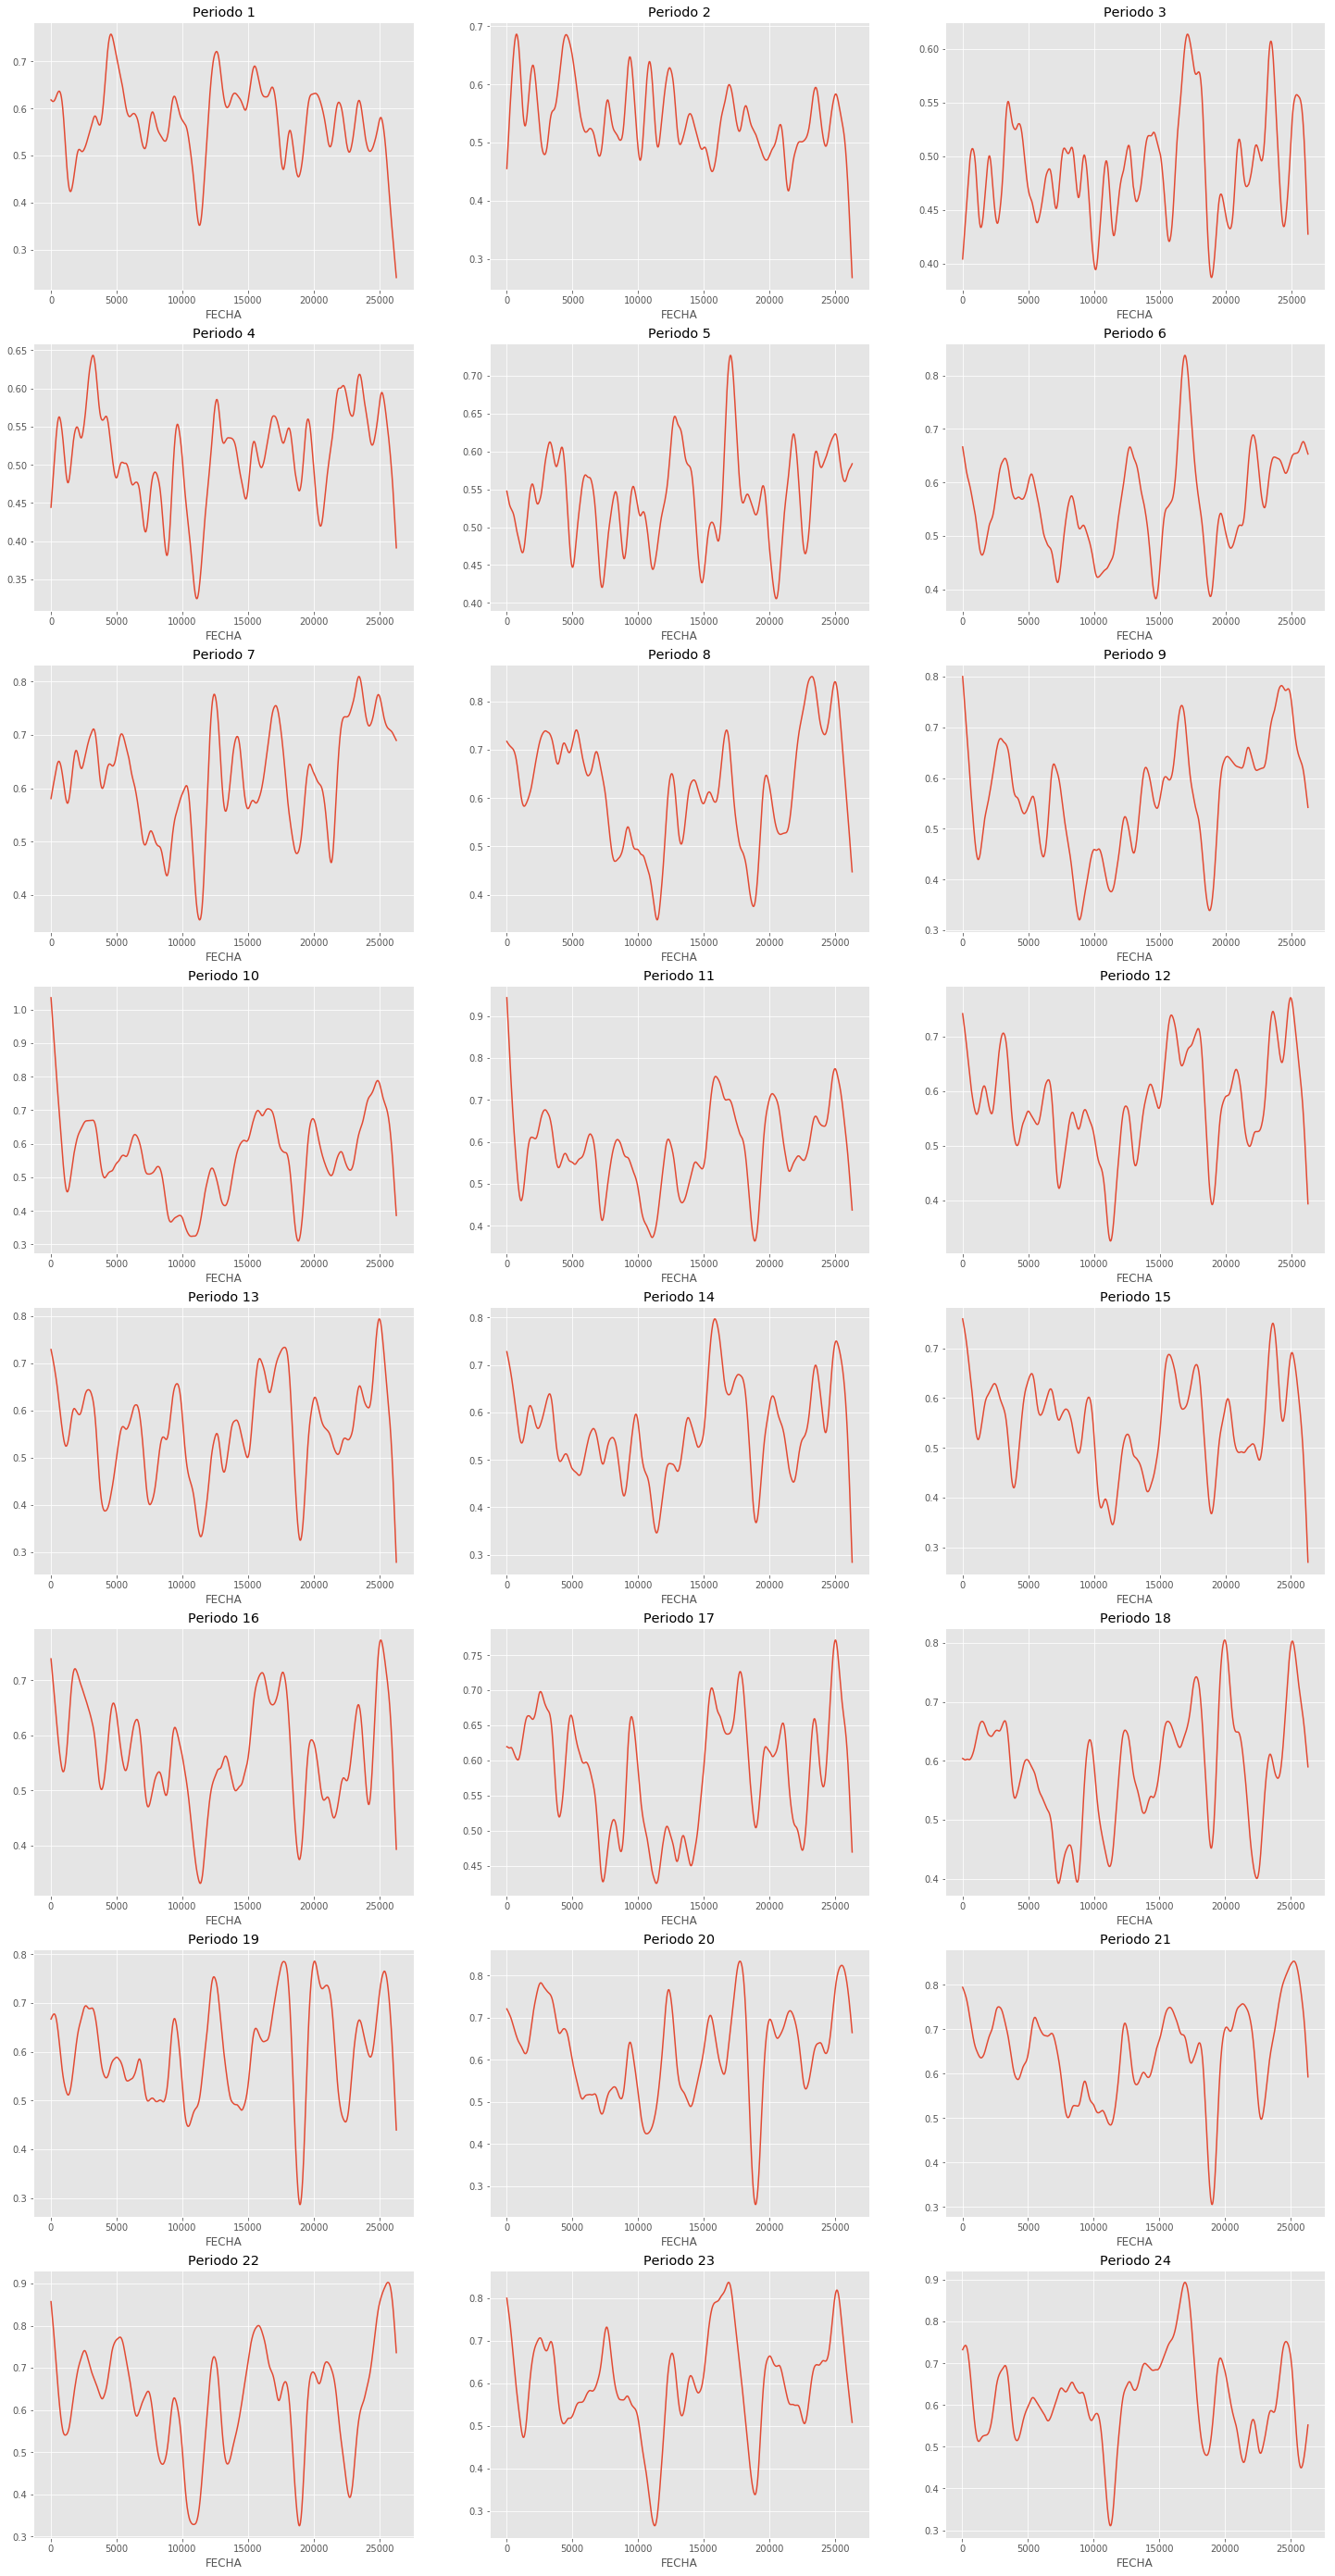

In [26]:
fig = plt.figure(figsize=(25,50))

for p in np.arange(24):
    plt.subplot(8,3,p+1)
    plt.title("Periodo " + str(p+1))
    subset=df_anho[df_anho['PERIODO']==p+1].copy()
    _, subset_tend = sm.tsa.filters.hpfilter(subset['RESERVA'],20000)
    subset['tend'] = pd.Series(subset_tend)
    plt.plot(subset['tend'],label='tend')
    plt.xlabel("FECHA") 

Sí parece dibujar cierta tendencia de mantenerse en el tiempo una situación. Sin embargo, he aplicado un suavizado elevado (con 10.000 de lambda se observa bastante más ruido) como para concluir una tendencia temporal tan solo con estos gráficos.

Resaltar que, en casi todas las horas, la curva termina en pendiente negativa bastante marcada.

Compruebo la proporción de horas en las que sube/baja el intradiario si el día anterior, en esa hora subió/bajó:

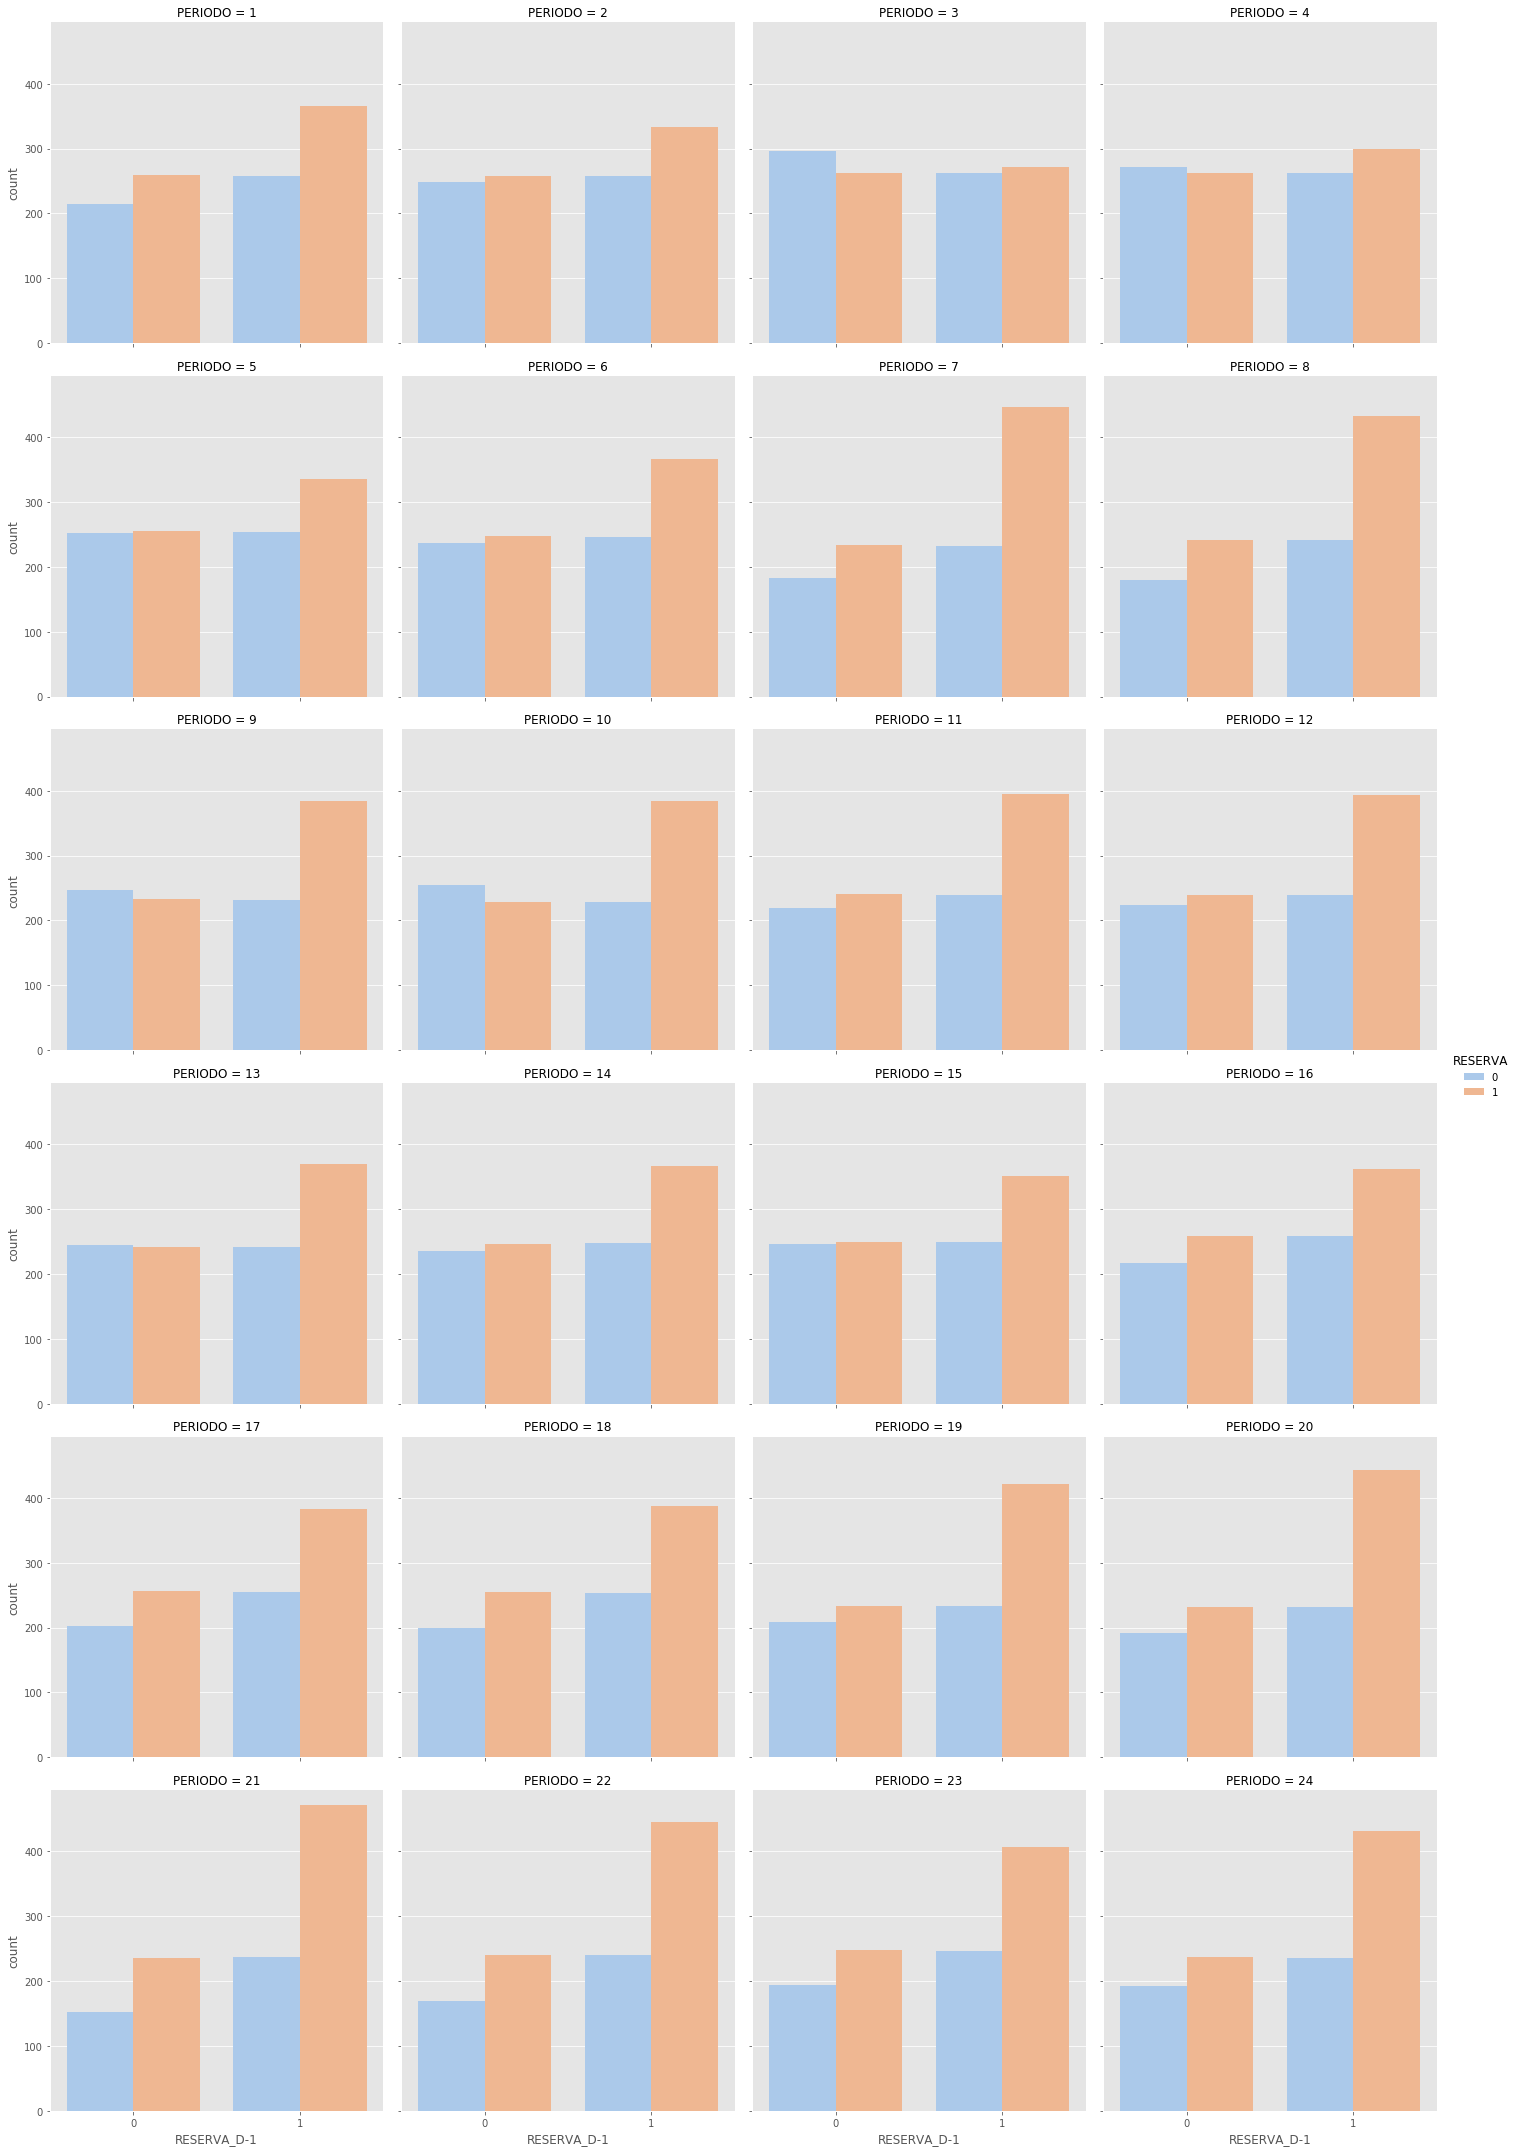

In [27]:
sns.catplot('RESERVA_D-1',data=df_anho, kind= 'count',
            hue='RESERVA',col='PERIODO',col_wrap=4,
            palette='pastel');

Hay más influencia en cómo se comportará RESERVA cuando RESERVA_D-1 = 1, es decir, cuando un día baja el intradiario (RESERVA_D-1 = 1) al día siguiente RESERVA = 1, mientras que cuando un día sube el intradiario lo que pase al día siguiente es más incierto (más próximo al 50%).

Esto se observa más en los periodos > 8. Las horas valle (de la h1 a la h8) son más volátiles.

### 2.3. ¿Es correcto, a priori, utilizar un dataset de 3 años?

Analizo cómo se comportaron las distintas variables cada año, para valorar si con 3 años se consigue abarcar diferentes escenarios que se puedan presentar en el futuro o si con un dataset más pequeño sería suficiente.

Además, agrupo por dato mensual para evaluar si es correcto utilizarlo como *feature* o va intrínseco en el comportamiento del resto de variables tras la duda anterior.

In [35]:
df_anho_1.describe()

,PERIODO,MES,WD,PRECIO_MD_ESP,ACOPLADO_FR,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,P48_CARBON_D-1,NUM_PLANTAS_D-1,EMB_ANUALES,EMB_HIPERANUALES,RESERVA,ANHO
count,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000,8783.0
mean,12.501082,6.514061,4.059775,38.347133,0.070249,0.582147,5717.254048,28290.361186,8764.754526,3957.501025,12.467494,5313.718092,5579.858818,0.582261,1.0
std,6.922232,3.451423,2.008625,13.824983,0.495212,0.493234,3259.886621,4497.364263,767.408112,2516.588641,7.138322,1231.348977,629.258607,0.493215,0.0
min,1.000000,1.000000,1.000000,2.300000,-1.000000,0.000000,281.600000,17728.400000,6794.400000,546.000000,3.000000,3714.000000,4778.000000,0.000000,1.0
25%,7.000000,4.000000,2.000000,30.300000,0.000000,0.000000,3198.350000,24441.900000,8273.800000,1534.850000,5.000000,3837.000000,4909.000000,0.000000,1.0
50%,13.000000,7.000000,4.000000,39.690000,0.000000,1.000000,5079.400000,28625.400000,8833.800000,3544.500000,11.000000,5609.000000,5538.000000,1.000000,1.0
75%,18.500000,10.000000,6.000000,46.645000,0.000000,1.000000,7551.000000,31834.550000,9419.100000,6297.100000,20.000000,6134.000000,6172.000000,1.000000,1.0
max,24.000000,12.000000,7.000000,85.000000,1.000000,1.000000,16670.800000,40329.400000,10070.400000,8768.300000,25.000000,7105.000000,6472.000000,1.000000,1.0


In [37]:
df_anho_2.describe()

,PERIODO,MES,WD,PRECIO_MD_ESP,ACOPLADO_FR,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,P48_CARBON_D-1,NUM_PLANTAS_D-1,EMB_ANUALES,EMB_HIPERANUALES,RESERVA,ANHO
count,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.0
mean,12.501085,6.526430,4.081859,51.869141,0.086425,0.553602,5051.412410,28631.728382,8403.119009,4983.807261,15.544583,3872.105149,3370.988812,0.554972,2.0
std,6.922233,3.448039,2.020118,11.534649,0.477583,0.497147,2909.568958,4590.374770,766.775829,1892.674732,5.326177,778.815437,574.456965,0.496997,0.0
min,1.000000,1.000000,1.000000,2.300000,-1.000000,0.000000,468.200000,18277.400000,5693.700000,921.200000,4.000000,2576.000000,2560.000000,0.000000,2.0
25%,7.000000,4.000000,2.000000,45.000000,0.000000,0.000000,2867.550000,24719.450000,7889.800000,3467.150000,11.000000,3148.000000,2852.000000,0.000000,2.0
50%,13.000000,7.000000,4.000000,50.930000,0.000000,1.000000,4456.600000,28896.500000,8535.500000,5294.900000,17.000000,3472.000000,3294.000000,1.000000,2.0
75%,18.500000,10.000000,6.000000,56.625000,0.000000,1.000000,6561.600000,32146.350000,8969.200000,6579.750000,20.000000,4709.000000,3843.000000,1.000000,2.0
max,24.000000,12.000000,7.000000,101.990000,1.000000,1.000000,16384.700000,41297.900000,9534.700000,8316.400000,24.000000,4931.000000,4491.000000,1.000000,2.0


In [38]:
df_anho_3.describe()

,PERIODO,MES,WD,PRECIO_MD_ESP,ACOPLADO_FR,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,P48_CARBON_D-1,NUM_PLANTAS_D-1,EMB_ANUALES,EMB_HIPERANUALES,RESERVA,ANHO
count,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.0
mean,12.501085,6.526430,4.101039,56.032261,0.089394,0.589451,5668.838292,29101.000662,8653.860475,4299.014739,13.105491,4696.079461,3509.681585,0.589451,3.0
std,6.922233,3.448039,2.032101,13.253325,0.499029,0.491962,3329.363919,4721.669470,649.892439,2074.705405,5.751540,1806.031249,1143.379475,0.491962,0.0
min,1.000000,1.000000,1.000000,2.060000,-1.000000,0.000000,240.800000,18591.400000,5808.600000,669.300000,2.000000,2222.000000,2138.000000,0.000000,3.0
25%,7.000000,4.000000,2.000000,49.440000,0.000000,0.000000,3023.950000,25033.300000,8334.200000,2346.050000,7.000000,2617.000000,2267.000000,0.000000,3.0
50%,13.000000,7.000000,4.000000,58.680000,0.000000,1.000000,4980.700000,29257.600000,8799.100000,4607.600000,14.000000,5172.000000,3731.000000,1.000000,3.0
75%,18.500000,10.000000,6.000000,64.400000,0.000000,1.000000,7789.300000,32891.000000,9153.600000,5987.900000,18.000000,5968.000000,4521.000000,1.000000,3.0
max,24.000000,12.000000,7.000000,90.000000,1.000000,1.000000,16952.600000,40921.600000,9534.700000,8656.100000,24.000000,7092.000000,5004.000000,1.000000,3.0


In [39]:
#Divido entre 1000 para expresarlo en GWh mensuales
df_mensual_1=df_anho_1[['P48_EOLICA','P48_DEMANDA','P48_CARBON_D-1','MES']].groupby('MES',sort=False).sum()/1000
df_mensual_2=df_anho_2[['P48_EOLICA','P48_DEMANDA','P48_CARBON_D-1','MES']].groupby('MES',sort=False).sum()/1000
df_mensual_3=df_anho_3[['P48_EOLICA','P48_DEMANDA','P48_CARBON_D-1','MES']].groupby('MES',sort=False).sum()/1000

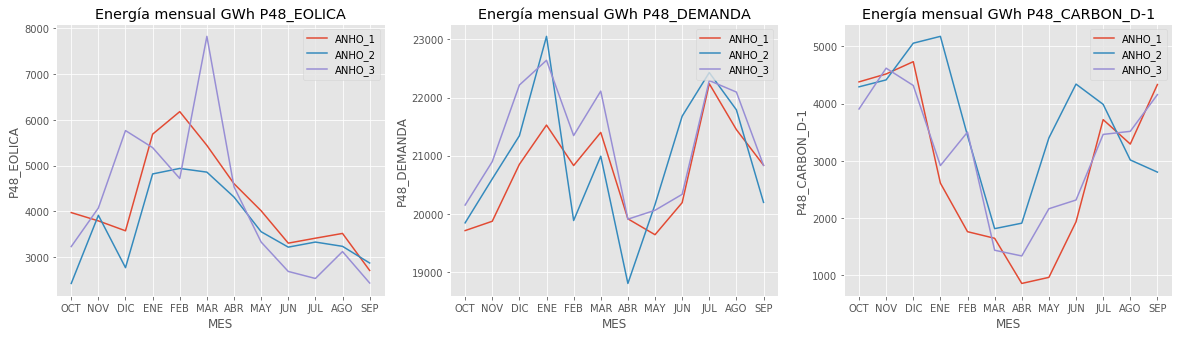

In [40]:
#Cambio los nombres de los ejes a string para que no me ordene automáticamente y no lleve a error: 
#Ejemplo: ANHO_1 va de octubre'15 a sept'16

df_mensual_1.rename(index={10:'OCT',11:'NOV',12:'DIC',1:'ENE',2:'FEB',3:'MAR',4:'ABR',5:'MAY',6:'JUN',7:'JUL',8:'AGO',9:'SEP'},inplace=True)
df_mensual_2.rename(index={10:'OCT',11:'NOV',12:'DIC',1:'ENE',2:'FEB',3:'MAR',4:'ABR',5:'MAY',6:'JUN',7:'JUL',8:'AGO',9:'SEP'},inplace=True)
df_mensual_3.rename(index={10:'OCT',11:'NOV',12:'DIC',1:'ENE',2:'FEB',3:'MAR',4:'ABR',5:'MAY',6:'JUN',7:'JUL',8:'AGO',9:'SEP'},inplace=True)

plt.figure(figsize=(20,5))
for i,col in enumerate(['P48_EOLICA','P48_DEMANDA','P48_CARBON_D-1']):
    plt.subplot(1,3,i+1)
    plt.title('Energía mensual GWh ' + col) 
    plt.plot(df_mensual_1[col],label='ANHO_1')
    plt.plot(df_mensual_2[col],label='ANHO_2')
    plt.plot(df_mensual_3[col],label='ANHO_3')
    plt.legend(loc='upper right')
    plt.xlabel('MES')    
    plt.ylabel(col)   
plt.show()


De momento sí se observa un perfil mensual en el comportamiento de las variables estudiadas.

Este comportamiento es análogo cada año en cuanto a perfil y nivel medio (y mediana) -> **De momento decido quedarme con los 3 años**. Sin embargo, el nivel de producción varía considerablemente de un año a otro algunos meses -> **Sigo contemplando la variable MES**.

Compruebo con otras variables:

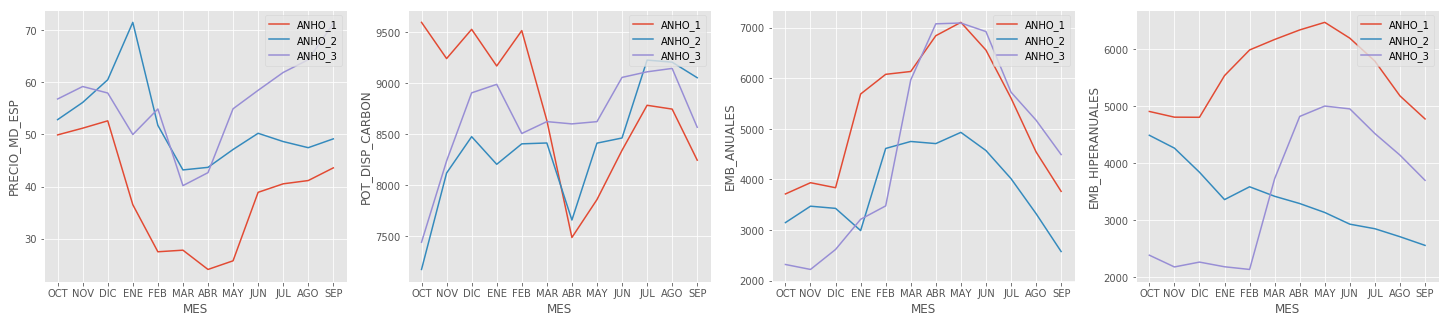

In [25]:
df_mensual_1mean=df_anho_1[['POT_DISP_CARBON','EMB_ANUALES','EMB_HIPERANUALES','PRECIO_MD_ESP','MES']].groupby('MES',sort=False).mean()
df_mensual_2mean=df_anho_2[['POT_DISP_CARBON','EMB_ANUALES','EMB_HIPERANUALES','PRECIO_MD_ESP','MES']].groupby('MES',sort=False).mean()
df_mensual_3mean=df_anho_3[['POT_DISP_CARBON','EMB_ANUALES','EMB_HIPERANUALES','PRECIO_MD_ESP','MES']].groupby('MES',sort=False).mean()

df_mensual_1mean.rename(index={10:'OCT',11:'NOV',12:'DIC',1:'ENE',2:'FEB',3:'MAR',4:'ABR',5:'MAY',6:'JUN',7:'JUL',8:'AGO',9:'SEP'},inplace=True)
df_mensual_2mean.rename(index={10:'OCT',11:'NOV',12:'DIC',1:'ENE',2:'FEB',3:'MAR',4:'ABR',5:'MAY',6:'JUN',7:'JUL',8:'AGO',9:'SEP'},inplace=True)
df_mensual_3mean.rename(index={10:'OCT',11:'NOV',12:'DIC',1:'ENE',2:'FEB',3:'MAR',4:'ABR',5:'MAY',6:'JUN',7:'JUL',8:'AGO',9:'SEP'},inplace=True)


plt.figure(figsize=(25,5))
for i,col in enumerate(['PRECIO_MD_ESP','POT_DISP_CARBON','EMB_ANUALES','EMB_HIPERANUALES']):
    plt.subplot(1,4,i+1)
    plt.plot(df_mensual_1mean[col],label='ANHO_1')
    plt.plot(df_mensual_2mean[col],label='ANHO_2')
    plt.plot(df_mensual_3mean[col],label='ANHO_3')
    plt.legend(loc='upper right')
    plt.xlabel('MES')    
    plt.ylabel(col)   
plt.show()

* La **Potencia Disponible de Carbón** va asociada a las paradas programadas de las plantas. Parece que suelen llevarse a cabo cada n meses.

* Vemos por años como ha variado la situación de los embalses.  Como se comentó en el punto 1), se distinguen dos tipos de embalses por ser distinta la disponibilidad de la aportación al mix de generación que tienen. Por ello no se juntan ambas variables en una. Se definen:

    * **Embalses anuales:** Embalses con una capacidad de regulación de sus reservas inferior a un año.
    * **Embalses hiperanuales:** Embalses con una capacidad de regulación de sus reservas superior a un año.

El vaciado y llenado de los embalses anuales, como se corrobora en el gráfico, va muy ligado al mes en el que se encuentra aunque los niveles alcanzados dependerán de la característica del año (húmedo/seco) y del nivel del que partían el año anterior. **Esto me corrobora que para conocer si estoy en época de vaciado o no de embalse anual, debo inluir el mes como variable**

Los embalses hiperanuales dependen mucho del momento de lluvias y de cómo es un año (seco/húmedo). Por ejemplo, en marzo 2018, tras un año 2017 caracterizado como seco (rampa descendiente ANHO_2) y un comienzo de año hidráulico sin pretensión, comienza el periodo de lluvias generalizado en toda España y con él el llenado de los embalses hiperanuales que se habían ido vaciado los años anteriores.

Por este motivo, se cogieron 3 años hidráulicos para intentar abarcar situaciones de hidraulicidad distintas: 

*2016 tenía un nivel elevado de hidráulica porque partía de años húmedos (2013, 2014 principalmente), pero a final de año comienzan las consecuencias de un año hidráulico seco que continúa durante 2017 y no se recupera hasta marzo de 2018.*


* Por último, el valor del **Precio_MD** medio mensual varía mucho de unos meses a otros y de un año a otro. Lo analizo más en detalle.

#### 2.3.1. Análisis de la variable PRECIO_MD_ESP: OUTLIERS

Se analiza esta variable más en profundidad. Posibles outliers y comportamiento de los mismos en cuanto a si después sube o baja el precio en los MMII (columna RESERVA) para tomar decisiones sobre mantenerlos o no.

Ya con la primera visual estadistística, la media, mediana y percentiles era muy distinta en el anho 1 frente al anho 2/3.

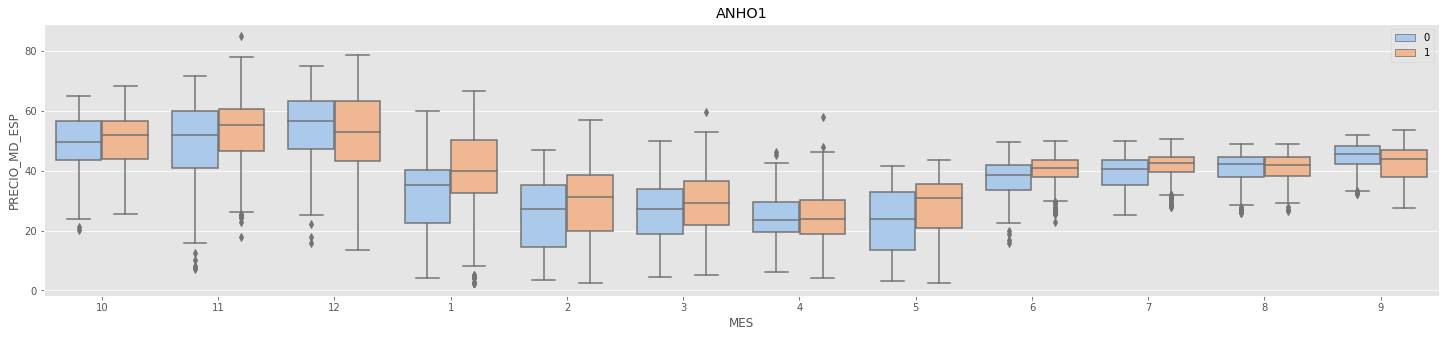

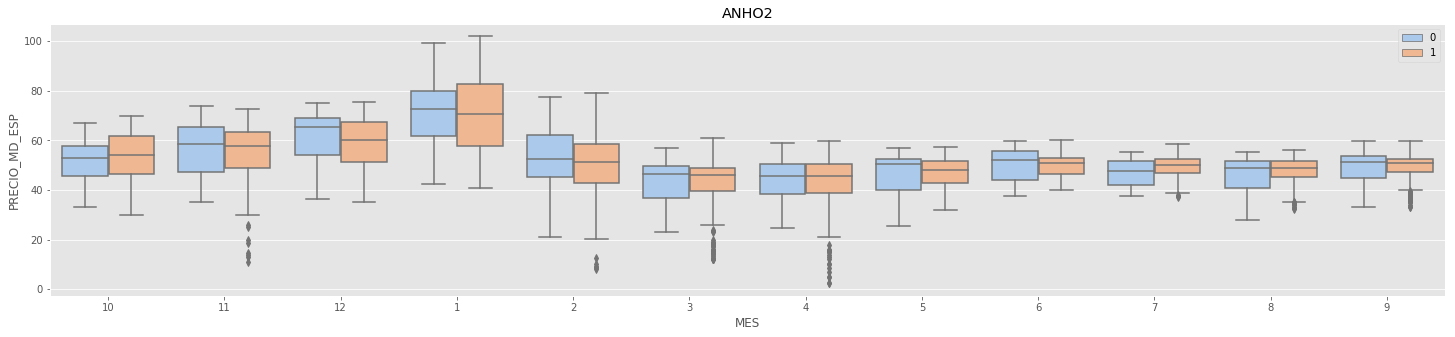

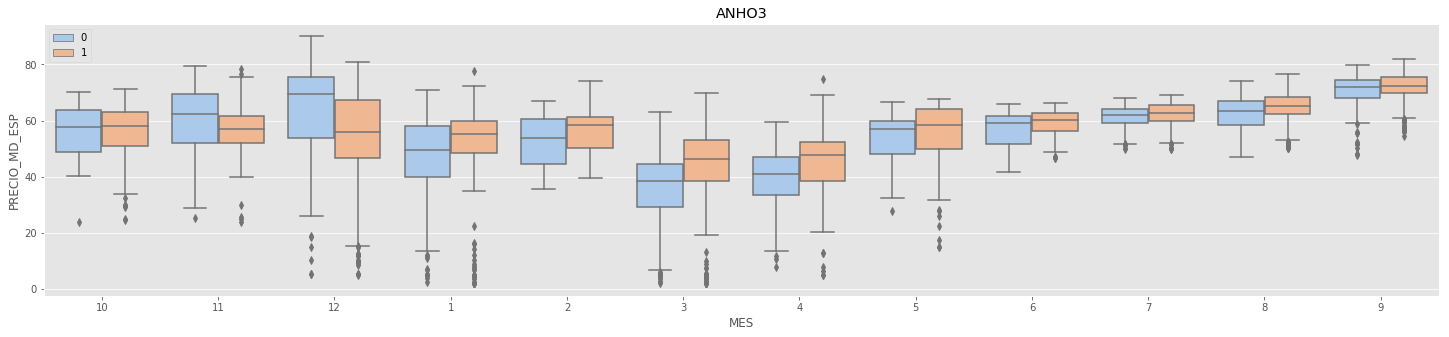

In [41]:
plt.figure(figsize=(25,5))
plt.title('ANHO1')
sns.boxplot(x='MES', y='PRECIO_MD_ESP', hue='RESERVA',order=order, data=df_anho_1,palette='pastel')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(25,5))
plt.title('ANHO2')
sns.boxplot(x='MES', y='PRECIO_MD_ESP', hue='RESERVA',order=order, data=df_anho_2,palette='pastel')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(25,5))
plt.title('ANHO3')
sns.boxplot(x='MES', y='PRECIO_MD_ESP', hue='RESERVA',order=order, data=df_anho_3,palette='pastel')
plt.legend(loc='best')
plt.show()

La media de los precios mensuales va creciendo cada año. Por ejemplo, el percentil 75 del año 3 está  en el mes 10 del anho_1 en el mes 10 está por debajo de la mediana del anho3. **Podría distorsionar la salida del modelo dependiendo del train-test set de datos que se escoja.**  

En el Q2 y Q3, en todos los años, se observa como los precios medios del mes se concentran más próximos a la media, mientras que en el Q1 (mayor incertidumbre meteorológica y dependencia de los niveles hidráulicos) existe más dispersión. Es en estos meses (enero, febrero, marzo) cuando podría parecer que a precios más elevados de PMD bajaría el intradiario.**El nivel de precio del MD cobra mayor importancia en el comportamiento del precio del intradiario en determinados meses -> Me indica quedarme con MES en mi dataset**

En todos los años parece existir más outliers de precios de MD bajos. Sin embargo, en los gráficos de cajas y bigotes representados, no se aprecia que impliquen una subida o bajada de los MMII directamente. Compruebo si es correcta esta afirmación:

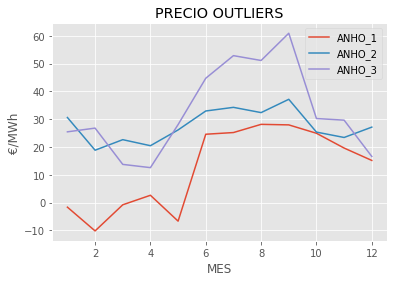

In [43]:
#Calculamos el IQR. Todo lo que esté por debajo de Q1-1.5IQR lo considero outlier (definición estadística)

IQR_1=df_anho_1[['PRECIO_MD_ESP','MES']].groupby('MES').quantile(0.75)-df_anho_1[['PRECIO_MD_ESP','MES']].groupby('MES').quantile(0.25)
IQR_2=df_anho_2[['PRECIO_MD_ESP','MES']].groupby('MES').quantile(0.75)-df_anho_2[['PRECIO_MD_ESP','MES']].groupby('MES').quantile(0.25)
IQR_3=df_anho_3[['PRECIO_MD_ESP','MES']].groupby('MES').quantile(0.75)-df_anho_3[['PRECIO_MD_ESP','MES']].groupby('MES').quantile(0.25)

Q1_1=df_anho_1[['PRECIO_MD_ESP','MES']].groupby('MES').quantile(0.25)
Q1_2=df_anho_2[['PRECIO_MD_ESP','MES']].groupby('MES').quantile(0.25)
Q1_3=df_anho_3[['PRECIO_MD_ESP','MES']].groupby('MES').quantile(0.25)

out_1=Q1_1-1.5*IQR_1
out_2=Q1_2-1.5*IQR_2
out_3=Q1_3-1.5*IQR_3

plt.title('PRECIO OUTLIERS')
plt.plot(out_1,label='ANHO_1')
plt.plot(out_2,label='ANHO_2')
plt.plot(out_3,label='ANHO_3')
plt.legend(loc='upper right')
plt.xlabel('MES')    
plt.ylabel('€/MWh') 
plt.show()

Como se apuntaba anteriormente, los precios considerados outliers en el ANHO 1 son mucho más bajos que los considerados outliers en los otros dos años -> **Distintos escenarios de precios de MD en los 3 años**.

In [44]:
df_subset_1=[]
for k,v in enumerate(df_anho_1['MES']):
    mes=v
    precio= df_anho_1['PRECIO_MD_ESP'].iloc[k]
    reserva=df_anho_1['RESERVA'].iloc[k]
    if precio < out_1['PRECIO_MD_ESP'].loc[mes]:
        df_subset_1.append([mes,precio,reserva])
df_subset_1=pd.DataFrame(df_subset_1,columns=['MES','PMD','RESERVA'])

df_subset_2=[]
for k,v in enumerate(df_anho_2['MES']):
    mes=v
    precio= df_anho_2['PRECIO_MD_ESP'].iloc[k]
    reserva=df_anho_2['RESERVA'].iloc[k]
    if precio < out_2['PRECIO_MD_ESP'].loc[mes]:
        df_subset_2.append([mes,precio,reserva])
df_subset_2=pd.DataFrame(df_subset_2,columns=['MES','PMD','RESERVA'])

df_subset_3=[]
for k,v in enumerate(df_anho_3['MES']):
    mes=v
    precio= df_anho_3['PRECIO_MD_ESP'].iloc[k]
    reserva=df_anho_3['RESERVA'].iloc[k]
    if precio < out_3['PRECIO_MD_ESP'].loc[mes]:
        df_subset_3.append([mes,precio,reserva])
df_subset_3=pd.DataFrame(df_subset_3,columns=['MES','PMD','RESERVA'])

In [45]:
print(df_subset_1['RESERVA'].value_counts(normalize=True,sort=False))
print(df_subset_2['RESERVA'].value_counts(normalize=True,sort=False))
print(df_subset_3['RESERVA'].value_counts(normalize=True,sort=False))

0    0.787234
1    0.212766
Name: RESERVA, dtype: float64
0    0.306122
1    0.693878
Name: RESERVA, dtype: float64
0    0.508091
1    0.491909
Name: RESERVA, dtype: float64


In [46]:
df_subset_1.groupby('MES')['PMD'].describe(),df_subset_2.groupby('MES')['PMD'].describe(),df_subset_3.groupby('MES')['PMD'].describe()

(     count       mean       std    min      25%     50%      75%    max
 MES                                                                    
 6     16.0  22.028750  2.638466  16.00  21.9050  22.765  23.7475  24.51
 8     14.0  26.877143  0.572316  25.97  26.5925  26.900  27.1250  27.80
 9      1.0  27.500000       NaN  27.50  27.5000  27.500  27.5000  27.50
 10     4.0  22.435000  2.088197  20.15  20.9300  22.595  24.1000  24.40
 11     9.0  12.706667  4.524909   7.20   8.0000  12.400  16.6000  18.00
 12     3.0  13.650000  0.251595  13.49  13.5050  13.520  13.7300  13.94,
      count       mean       std    min      25%     50%      75%    max
 MES                                                                    
 2      6.0   9.513333  1.565103   8.00   8.8600   8.860   9.7900  12.40
 3     25.0  15.061200  2.449352  12.00  12.4000  15.000  17.2600  20.00
 4     17.0  10.858824  5.028376   2.30   7.0900  12.120  15.0400  18.00
 5      2.0  25.430000  0.000000  25.43  25.4300  

En los primeros apartados de este notebook se veía como predominaban las horas de bajada de precio del intradiario frente a las que subían, aunque la diferencia no era lo suficientemente grande como para considerar mi dataset desbalanceado hacia ese lado.

En los casos de los precios del MD extremos a la baja, se corportan de manera diferente un año y otro: el primer año, donde el valor *OUTLIER* es más bajo, sí se observa una tendencia clara de subida del intradiario (78%) a ese nivel. Sin embargo, la situación se da completamente la vuelta en el ANHO_2 y queda equilibrado en el ANHO_3. Es cierto que el precio que se considera outlier es muy superior en el ANHO_3 que en el ANHO_1. 

Por tanto parece que ante precios extremos a la baja, sí pueda subir claramente el intradiario, pero ante valores muy bajos independientemente del mes/año en el que te encuentres. Este dato lo interpreto como que el nivel del PRECIO_MD_ESP puede ser importante en mi modelo.

Otro dato a comentar es que el número de outliers es muy superior el 3º año frente al resto.

* **Con todo esto, decido mantener los outliers en mi dataset**.

* **NOTA: Tendré que tener en cuenta a la hora de entrenar el modelo, que el ANHO_1 recoge precios del mercado diario muy inferiores a los siguientes años.**

#### 2.3.2. Análisis de la variable PRECIO_MD_ESP con otras variables: ACOPLADO FR

El precio del MD está muy influenciado por el precio del mercado diario francés gracias a la interconexión que permite un flujo de energía entre ambos países.

Cuando ambos países están acoplados, el precio de la hora es el mismo, y todavía está disponible más capacidad en esa misma dirección para que fluya energía del país más barato al más caro. Si la interconexión se satura en un sentido, ambos mercados se separan.

Desde el punto de vista del mercado intradiario, con ambos mercados acoplados Francia se comportaría como una central de generación más (cuando Precio FR < Precio ESP) o un consumidor en el caso opuesto, por eso decidí considerarlo en este dataset.

Desde octubre'15 se duplicó la capacidad comercial de la misma hasta los 2.800 MW y el objetivo es llegar a los 10.000 MW exigidos por la UE para 2020 gracias a la nueva interconexión submarina por el Golfo de Bizkaia.

        Más info: https://www.ree.es/es/red21/refuerzo-de-las-interconexiones

Como en el dataset ya disponíamos de la máxima capacidad (salvo indisponibilidades o mantenimientos), no es necesario discriminar por años.

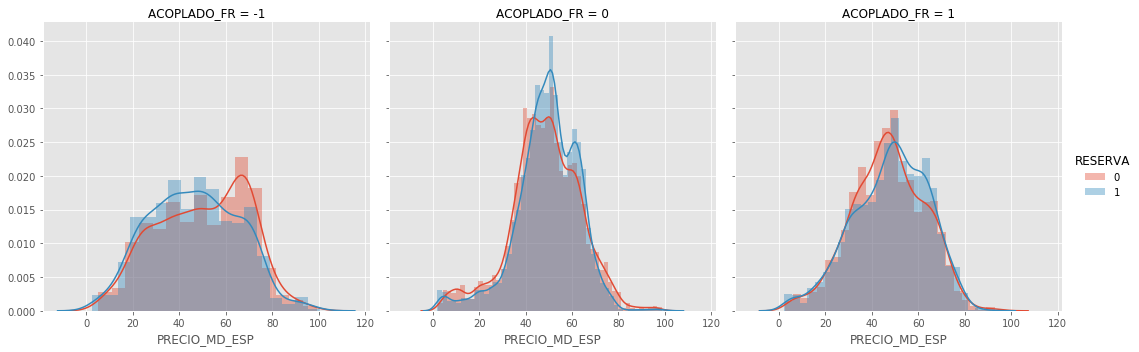

In [47]:
g = sns.FacetGrid(df_anho, hue= 'RESERVA', col='ACOPLADO_FR',height=5,aspect=1)
g.map(sns.distplot, 'PRECIO_MD_ESP',kde=True).add_legend();

Destaca distribución del precio más apuntada (concentración de datos en la media) cuando no están ambos mercados acoplados. Esto lo interpreto como que el precio de Francia arrastra a precios más extremos el precio de España. La distribución del mismo cuando baja el intra y cuando sube no cambia.

En cuanto a si esta influencia existe también en el comportamiento del precio del MI1 con respecto al MD:

1) Cuando ambos mercados están acoplados y España exporta a Francia (-1) se observa mayor número de veces en las que el intradiario sube a precios del PMD más altos (curva distribución desplazada a la derecha) y lo opuesto a precios bajos.

2) En el otro sentido de la interconexión, cuando es Francia la que exporta a España, ambas curvas (Reserva 0/1) se encuentran más centradas alrededor de la media, ligeramente mostrando el comportamiento inverso al punto 1 (subida del precio a precios más bajos).

In [48]:
df_anho.groupby('ACOPLADO_FR')['RESERVA'].value_counts(normalize=True,sort=False)

ACOPLADO_FR  RESERVA
-1           0          0.502526
             1          0.497474
 0           0          0.415260
             1          0.584740
 1           0          0.427088
             1          0.572912
Name: RESERVA, dtype: float64

### 2.4. Estudio de la distribución de las variables

#### 2.4.1. Estudio univariante

Estudio de la distribución de cada variable:

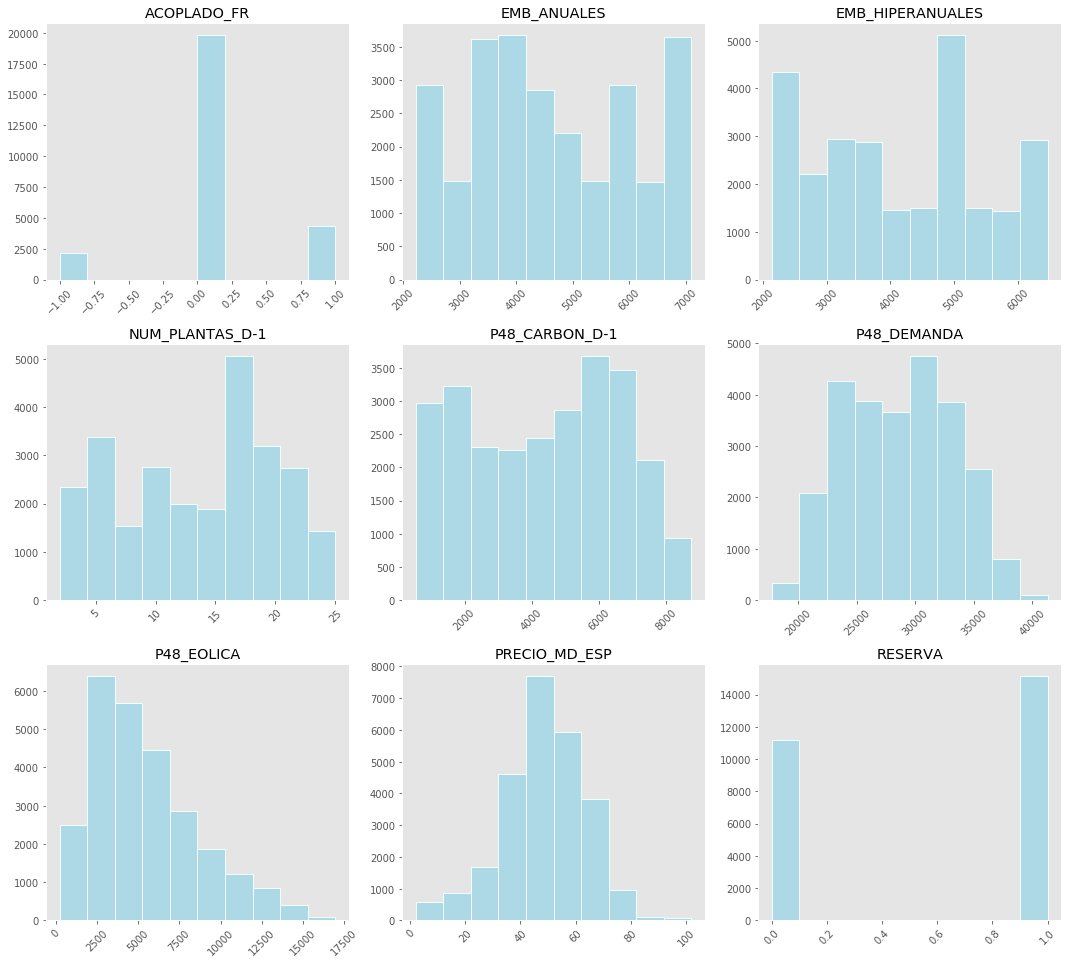

In [49]:
fig = df_anho.drop(['MES','PERIODO','ANHO','WD','RESERVA_D-1','POT_DISP_CARBON'],axis=1).hist(color='lightblue',
                                                                                             edgecolor='azure', linewidth=1.0,
                                                                                             xlabelsize=10, ylabelsize=10,
                                                                                             xrot=45, yrot=0,
                                                                                             figsize=(10,9),
                                                                                             grid=False)
plt.tight_layout(rect=(0, 0, 1.5, 1.5))  


* Como ya se vió en el apartado anterior, el nº de horas en las que francia está desacoplado de España es muy superior -> **Tendré que evaluar qué importancia tiene en los distintos modelos. Podría darse el caso que en el train set no haya ningún día de acoplado FR (o muy pocos) y empeore el accuracy de mi modelo.**

In [50]:
df_anho.groupby('ACOPLADO_FR')['FECHA'].count()/len(df_anho['FECHA'])*100

ACOPLADO_FR
-1     8.277252
 0    75.244287
 1    16.478461
Name: FECHA, dtype: float64

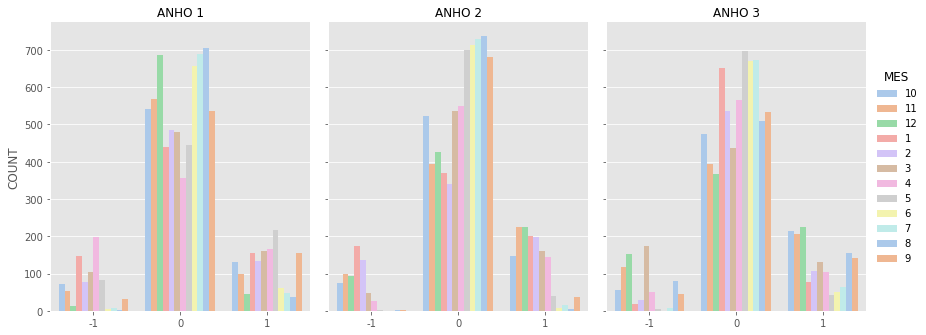

In [51]:
g = sns.catplot('ACOPLADO_FR', col='ANHO',hue='MES',
                 hue_order=order, data=df_anho,
                 kind="count", ci=None, aspect=.8,
                 palette='pastel')
(g.set_axis_labels('', 'COUNT')
.set_titles('{col_var} {col_name}'));


* Distribución "uniforme" de los embalses hiperanuales que indicaría que contamos practicamente por igual con todos los escenarios. En los embalses anuales sí se observan valores que sobresalen (niveles de 5.000 GWh y 2.000 GWh serían los más frecuentes).

* También, tanto el nº de plantas arrancadas como el carbón disponible muestran distribuciones aceptablemente uniformes.

* La eolicidad en nuestro dataset se concentra más en niveles bajos (distribución desplazada a la izquieda). Los valores más altos se suelen dar tan solo en el Q1 (gráfica de energía eólica mensual).

* La distribución del PMD se encuentra centrada alrededor de la media en el conjunto de los 3 años. 

#### 2.4.1. Estudio relación entre variables

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


[]

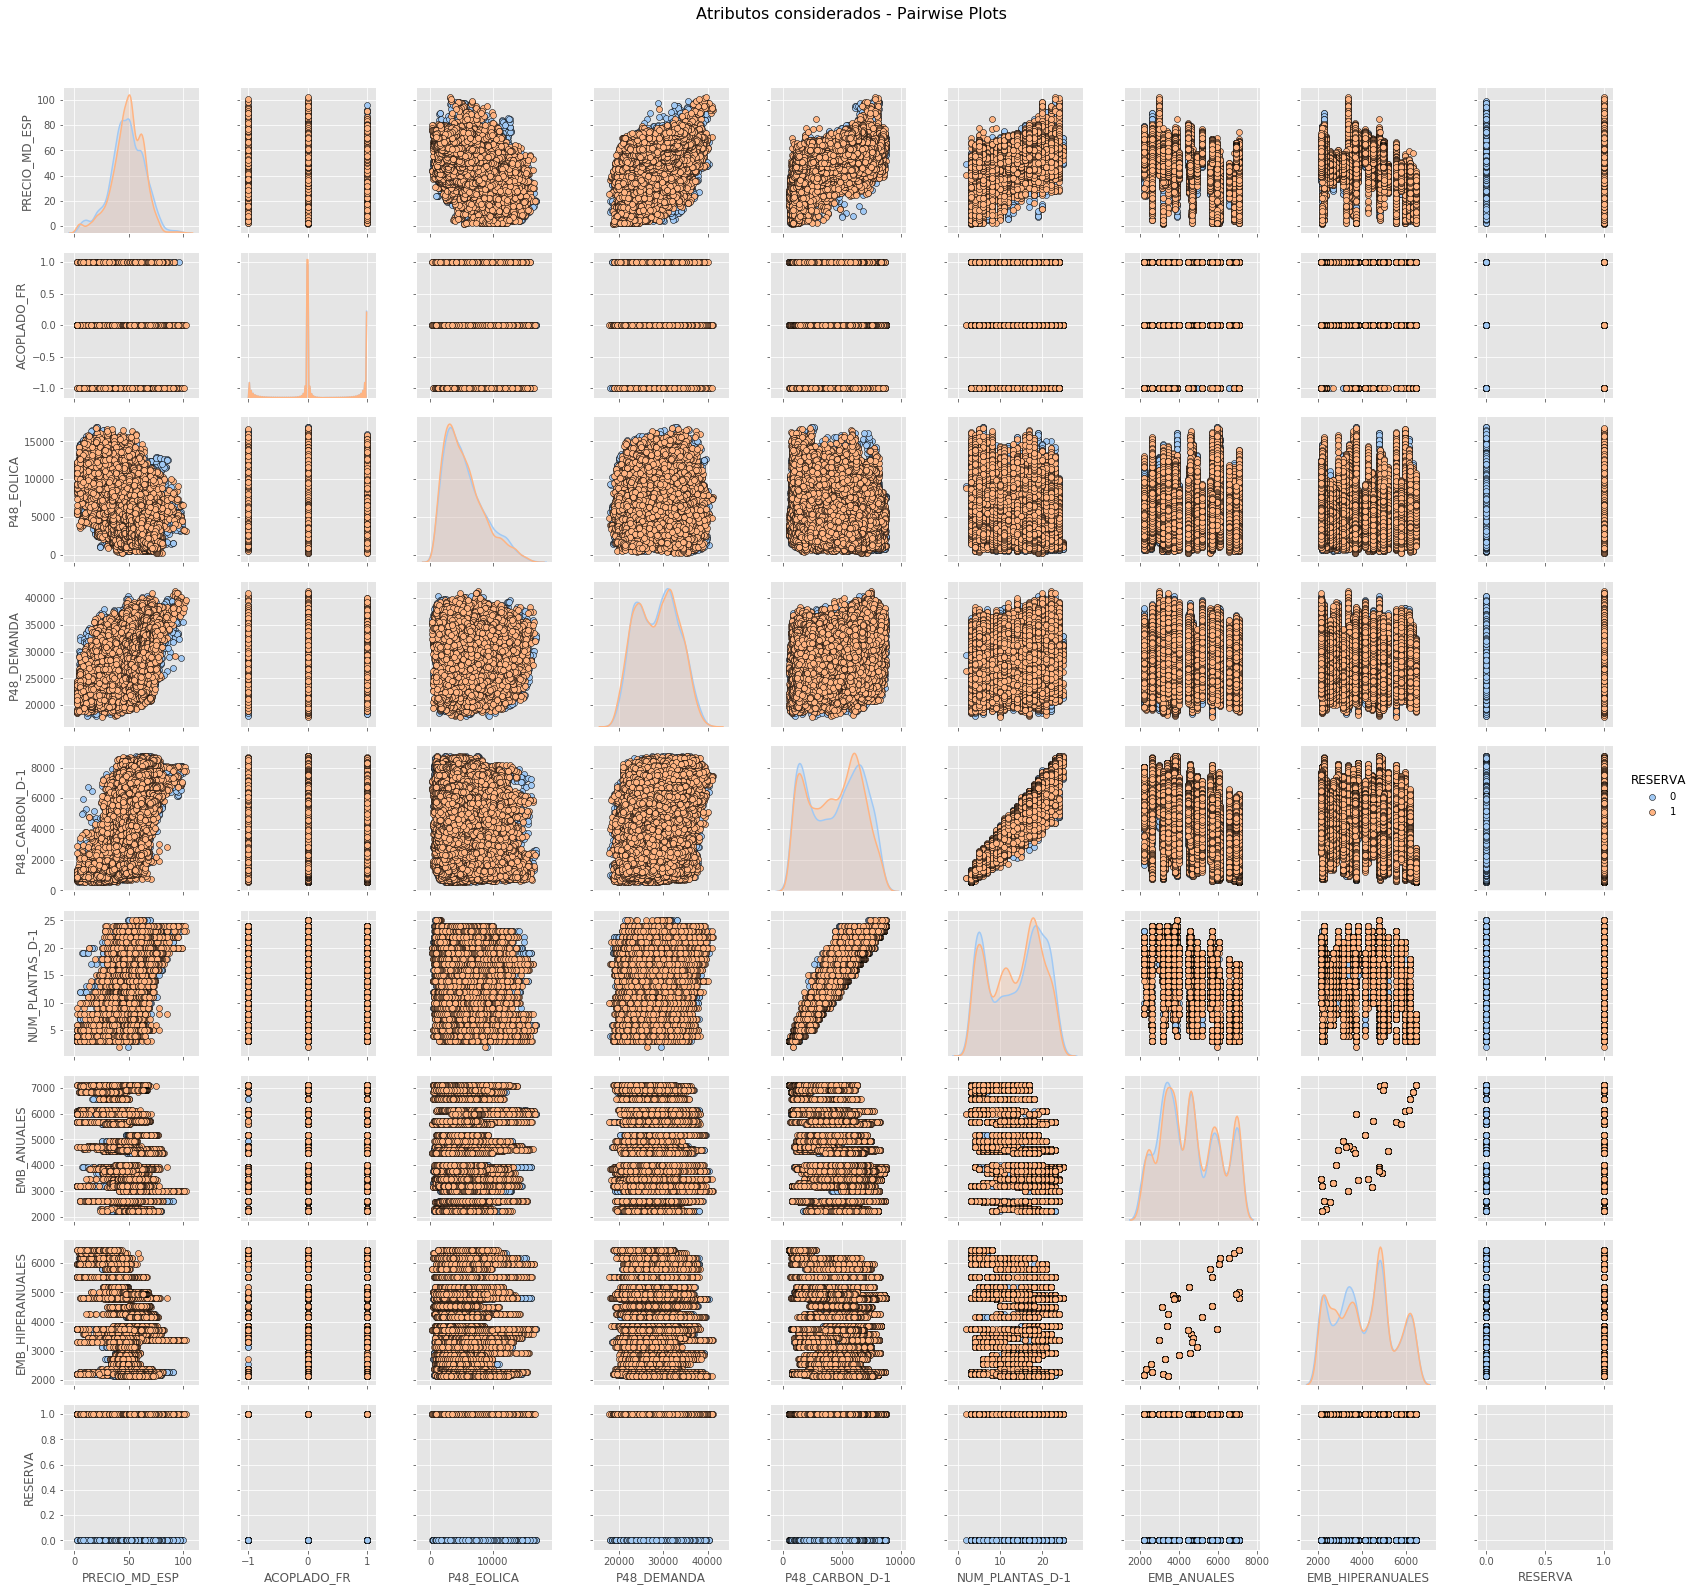

In [52]:
pp = sns.pairplot(data=df_anho.drop(['MES','PERIODO','ANHO','WD','RESERVA_D-1','POT_DISP_CARBON'],axis=1), 
                  hue='RESERVA',
                  palette='pastel',
                  plot_kws=dict(edgecolor='black', linewidth=0.5))
fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
fig.suptitle('Atributos considerados - Pairwise Plots', fontsize=16)
plt.plot()

## 3) Estudio correlaciones:

In [53]:
correlations=df_anho.drop('ANHO',axis=1).corr()

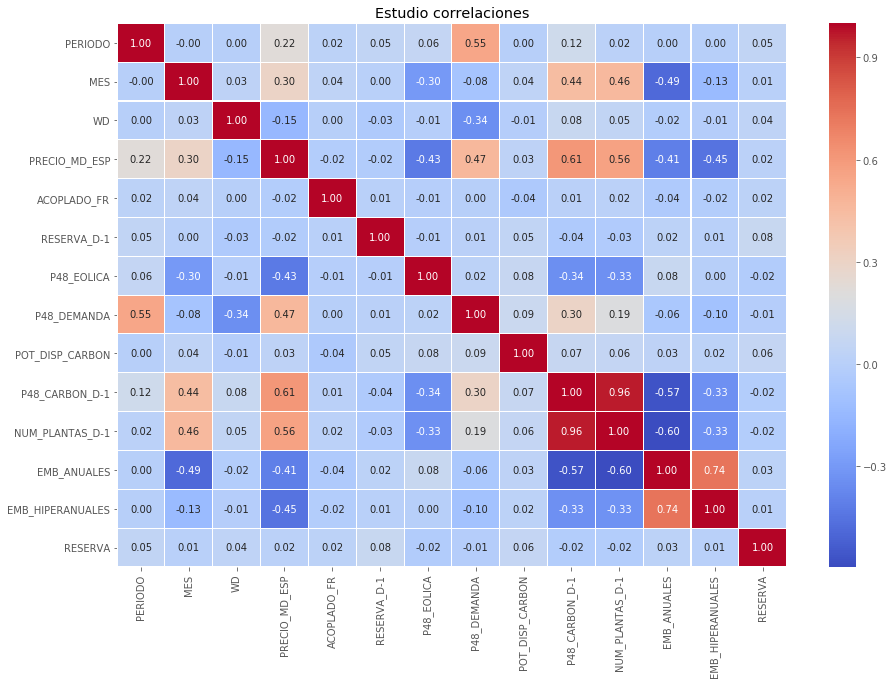

In [54]:
plt.figure(figsize=(15,10))
sns.heatmap(data=correlations,cmap='coolwarm', 
            annot=True, 
            fmt='.2f',       
            linewidths=.05)
plt.title('Estudio correlaciones')
plt.show()

Existe una correlacion lineal directa entre el número de plantas de carbón arrancadas y la generación de carbón. Tiene sentido ya que normalmente las plantas no se quedan funcionando a mínimo técnico (menos eficientes) si no que una vez arrancadas buscan generar lo máximo posible.

Visto esto, creo una variable que englobe ambas. Esta nueva variable la llamo CARBON_D-1 y será:

        CARBON_D-1 = P48_CARBON_D-1 / NUM_PLANTAS_D-1

In [55]:
df_definitivo=df_anho.copy()

In [56]:
df_definitivo['CARBON_D-1']=round(df_definitivo['P48_CARBON_D-1'] / df_definitivo['NUM_PLANTAS_D-1'],2)
df_definitivo['CARBON_D-1'].describe()

count    26301.000000
mean       315.052795
std         50.909778
min        143.340000
25%        280.290000
50%        327.000000
75%        351.950000
max        517.780000
Name: CARBON_D-1, dtype: float64

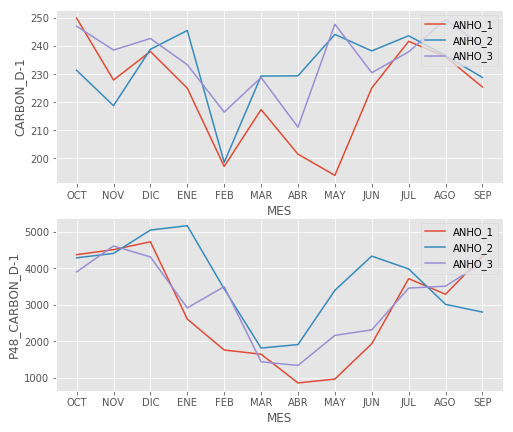

In [57]:
df_definitivo_1=df_definitivo[df_definitivo['ANHO']==1]
df_definitivo_2=df_definitivo[df_definitivo['ANHO']==2]
df_definitivo_3=df_definitivo[df_definitivo['ANHO']==3]

df_mensualdef_1=df_definitivo_1[['CARBON_D-1','MES']].groupby('MES',sort=False).sum()/1000
df_mensualdef_2=df_definitivo_2[['CARBON_D-1','MES']].groupby('MES',sort=False).sum()/1000
df_mensualdef_3=df_definitivo_3[['CARBON_D-1','MES']].groupby('MES',sort=False).sum()/1000

df_mensualdef_1.rename(index={10:'OCT',11:'NOV',12:'DIC',1:'ENE',2:'FEB',3:'MAR',4:'ABR',5:'MAY',6:'JUN',7:'JUL',8:'AGO',9:'SEP'},inplace=True)
df_mensualdef_2.rename(index={10:'OCT',11:'NOV',12:'DIC',1:'ENE',2:'FEB',3:'MAR',4:'ABR',5:'MAY',6:'JUN',7:'JUL',8:'AGO',9:'SEP'},inplace=True)
df_mensualdef_3.rename(index={10:'OCT',11:'NOV',12:'DIC',1:'ENE',2:'FEB',3:'MAR',4:'ABR',5:'MAY',6:'JUN',7:'JUL',8:'AGO',9:'SEP'},inplace=True)


plt.figure(figsize=(8,7))
plt.subplot(2,1,1)
plt.plot(df_mensualdef_1['CARBON_D-1'],label='ANHO_1')
plt.plot(df_mensualdef_2['CARBON_D-1'],label='ANHO_2')
plt.plot(df_mensualdef_3['CARBON_D-1'],label='ANHO_3')
plt.legend(loc='upper right')
plt.xlabel('MES')    
plt.ylabel('CARBON_D-1')   

plt.subplot(2,1,2)
plt.plot(df_mensual_1['P48_CARBON_D-1'],label='ANHO_1')
plt.plot(df_mensual_2['P48_CARBON_D-1'],label='ANHO_2')
plt.plot(df_mensual_3['P48_CARBON_D-1'],label='ANHO_3')
plt.legend(loc='upper right')
plt.xlabel('MES')    
plt.ylabel('P48_CARBON_D-1') 


plt.show()

La evolución de la curva varía ligeramente al englobar ambas variables (disminuye el ruido)

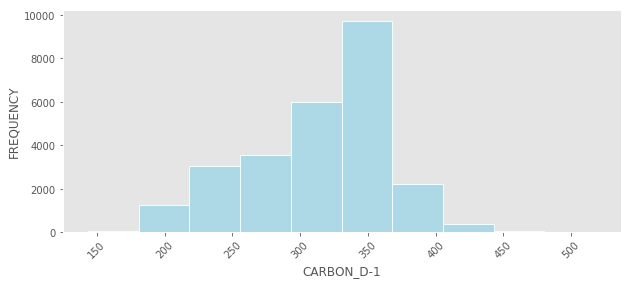

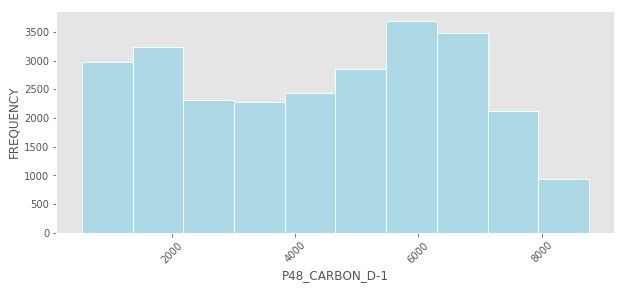

In [58]:

plt.figure(figsize=(8,7))
plt.subplot(2,1,1)
df_definitivo['CARBON_D-1'].hist(color='lightblue',
                                edgecolor='azure', linewidth=1.0,
                                xlabelsize=10, ylabelsize=10,
                                xrot=45, yrot=0,
                                figsize=(10,9),
                                grid=False)
plt.xlabel('CARBON_D-1')    
plt.ylabel('FREQUENCY') 
plt.show()


plt.subplot(2,1,2)
df_anho['P48_CARBON_D-1'].hist(color='lightblue',
                                edgecolor='azure', linewidth=1.0,
                                xlabelsize=10, ylabelsize=10,
                                xrot=45, yrot=0,
                                figsize=(10,9),
                                grid=False)

plt.xlabel('P48_CARBON_D-1')    
plt.ylabel('FREQUENCY') 
plt.show()
plt.show()

La distribución de la nueva variable presenta mayor normalidad, ligeramente desplazada a la derecha.

## 4) Conclusiones

* No existe desbalanceo del target RESERVA en el conjunto de datos. (Ligeramente en algunos meses, sin patrón definido)

* Aplicar cross-validation para selección de hiperparámetros.

* Considero en el modelo los feature de tiempo (mes, hora, WD...). Aplicaré funcionalidad train_test_split.

* No elimino outliers de precio -> no distorsionan dataset

* Con tres años consigo contemplar distintos escenarios de precios, hidraulicidad, eolicidad. Sin embargo, en el caso de la variable PRECIO_MD tengo dudas si esto supondrá un problema -> Tendré que evaluar si el modelo mejora o no al reducir el número de años y ver la importancia que tiene la variable en el mismo.

* No agrupo GWh de los embalses por tener comportamiento distinto.

* Desbalanceo del nº de veces en las que el mercado español acoplado con el mercado francés -> cuidado con seleccion trainset (varias repeticiones) y valorar eliminarla del dataset.

* Agrupamiento de las variables de generación de carbón en D-1 y el nº de centrales arrancadas -> normalidad de los datos.

* A priori, no descarto ninguna de las variables seleccionadas (pendiente ACOPLADO_FR)

* No existe correlación lineal entre las variables de estudio tras la creación de la nueva variable CARBON_D-1.

* Data_set para modelo: **data_processed_definitive**

In [59]:
df_definitivo.columns

Index(['FECHA', 'PERIODO', 'MES', 'WD', 'PRECIO_MD_ESP', 'ACOPLADO_FR',
       'RESERVA_D-1', 'P48_EOLICA', 'P48_DEMANDA', 'POT_DISP_CARBON',
       'P48_CARBON_D-1', 'NUM_PLANTAS_D-1', 'EMB_ANUALES', 'EMB_HIPERANUALES',
       'RESERVA', 'ANHO', 'CARBON_D-1'],
      dtype='object')

In [60]:
df_definitivo=df_definitivo[['FECHA', 'PERIODO', 'MES', 'WD', 'PRECIO_MD_ESP', 'ACOPLADO_FR',
       'RESERVA_D-1', 'P48_EOLICA', 'P48_DEMANDA', 'POT_DISP_CARBON',
       'CARBON_D-1', 'EMB_ANUALES', 'EMB_HIPERANUALES','RESERVA']]
df_definitivo.head(3)

,FECHA,PERIODO,MES,WD,PRECIO_MD_ESP,ACOPLADO_FR,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,CARBON_D-1,EMB_ANUALES,EMB_HIPERANUALES,RESERVA
0,2015-10-01,1,10,4,56.65,0,0,2196.1,24517.1,10060.7,326.43,3714,4909,1
1,2015-10-01,2,10,4,53.50,0,0,2064.4,23168.6,10060.7,307.80,3714,4909,0
2,2015-10-01,3,10,4,49.69,0,0,1866.5,22437.2,10060.7,298.16,3714,4909,0


In [61]:
df_definitivo.to_csv("../data_processed/data_processed_definitive.csv",sep=';',index= False)